# Final Project
## Predict the next-day Bitcoin price. 


Firstly we have done an EDA in order to prepare the data for later use in prediction algorithms. For which, we developed two prediction models, the first, SGDRegressor and the second is LSTM.

 We start importing the necesary libraries for this project. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import SGDRegressor
import quandl
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# 1. Data preparation

Use YFinance for the bitcoin market. We get the following columns:

    *Date*
    *Open*. The opening price of that day. (the first price of the day)
    *High* The highest price of that day.
    *Low* The lowest price of that day.
    *Close* The closing price of the day (That day’s last price)
    *Volume* The amount of Bitcoin traded on that day.
Download the Standard & Poor's 500 Index and get the API Key from Quandl 

    

In [2]:
# Open
bitcoin = yf.Ticker("BTC-USD")

# Get historical market data
bit_hist = bitcoin.history(period="max")
# Drop the columns that are not needed
bit_hist.drop(columns=['Dividends','Stock Splits'],inplace=True)
# Rename the columns
bit_hist.rename(columns={'Open': 'Bitcoin_Open', 'High': 'Bitcoin_High', 'Low': 'Bitcoin_Low', 'Close': 'Bitcoin_Close', 'Volume': 'Bitcoin_Volume'}, inplace=True)
bit_hist.reset_index(inplace=True)
bit_hist['Date'] = bit_hist['Date'].dt.strftime('%d/%m/%y')
# Download the Standard & Poor's 500 Index
sp500 = yf.Ticker("^GSPC")
# Get historical market data
sp500_hist = sp500.history(period="20y")
# Drop the columns that are not needed
sp500_hist.drop(columns=['Dividends','Stock Splits'],inplace=True)
# Rename the columns
sp500_hist.rename(columns={'Open': 'SP500_Open', 'High': 'SP500_High', 'Low': 'SP500_Low', 'Close': 'SP500_Close', 'Volume': 'SP500_Volume'}, inplace=True)
sp500_hist.reset_index(inplace=True)
sp500_hist['Date'] = sp500_hist['Date'].dt.strftime('%d/%m/%y')
# Merge the two dataframes
pd.merge(bit_hist,sp500_hist,how='left')



Date  Bitcoin_Open  Bitcoin_High   Bitcoin_Low  Bitcoin_Close  \
0     17/09/14    465.864014    468.174011    452.421997     457.334015   
1     18/09/14    456.859985    456.859985    413.104004     424.440002   
2     19/09/14    424.102997    427.834991    384.532013     394.795990   
3     20/09/14    394.673004    423.295990    389.882996     408.903992   
4     21/09/14    408.084991    412.425995    393.181000     398.821014   
...        ...           ...           ...           ...            ...   
3524  11/05/24  60793.355469  61451.152344  60492.625000   60793.710938   
3525  12/05/24  60793.503906  61818.156250  60632.601562   61448.394531   
3526  13/05/24  61451.218750  63422.660156  60769.839844   62901.449219   
3527  14/05/24  62900.773438  63092.125000  61123.765625   61552.789062   
3528  15/05/24  61549.578125  62896.226562  61358.839844   62631.992188   

      Bitcoin_Volume   SP500_Open   SP500_High    SP500_Low  SP500_Close  \
0           21056800  1999.300049  2010.739990  1993.290039  2001.569946   
1           34483200  2003.069946  2012.339966  2003.069946  2011.359985   
2           37919700  2012.739990  2019.260010  2006.589966  2010.400024   
3           36863600          NaN          NaN          NaN          NaN   
4           26580100          NaN          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
3524     13842272968          NaN          NaN          NaN          NaN   
3525     13800459405          NaN          NaN          NaN          NaN   
3526     27889181179  5233.080078  5237.259766  5211.160156  5221.419922   
3527     28186271527  5221.100098  5250.370117  5217.979980  5246.680176   
3528     25921966080          NaN          NaN          NaN          NaN   

      SP500_Volume  
0     3.209420e+09  
1     3.235340e+09  
2     4.880220e+09  
3              NaN  
4              NaN  
...            ...  
3524           NaN  
3525           NaN  
3526  4.255710e+09  
3527  4.763580e+09  
3528           NaN  

[3529 rows x 11 columns]

In [3]:
# API
# Download the gold price
quandl.api_key = "eznmz84KQ_xM2-Qfz5Yz"
gold_data = quandl.get("LBMA/GOLD", start_date = "2011-01-01", end_date = "2021-12-31")
gold_data.reset_index(inplace=True)
gold_data['Date'] = gold_data['Date'].dt.strftime('%d/%m/%y')
print(gold_data)
# Merge the dataframes
merged_data = pd.merge(bit_hist, gold_data, on='Date', how='left')
merged_data = pd.merge(merged_data, sp500_hist, on='Date', how='left')
merged_data.head()




          Date  USD (AM)  USD (PM)  GBP (AM)  GBP (PM)  EURO (AM)  EURO (PM)
0     04/01/11   1405.50   1388.50   898.772   890.407    1048.88    1039.14
1     05/01/11   1382.75   1368.00   886.151   882.012    1044.06    1039.12
2     06/01/11   1376.00   1368.50   889.463   882.732    1050.70    1046.65
3     07/01/11   1358.00   1367.00   879.078   880.799    1045.98    1053.16
4     10/01/11   1368.25   1368.25   882.685   881.888    1060.33    1060.41
...        ...       ...       ...       ...       ...        ...        ...
2775  23/12/21   1805.55   1805.20  1345.320  1346.500    1594.12    1595.98
2776  24/12/21   1786.05       NaN  1331.680       NaN    1575.47        NaN
2777  29/12/21   1796.35   1794.25  1338.820  1331.330    1591.93    1581.27
2778  30/12/21   1799.25   1805.85  1335.040  1336.510    1590.72    1593.48
2779  31/12/21   1820.10       NaN  1347.060       NaN    1606.06        NaN

[2780 rows x 7 columns]


Date  Bitcoin_Open  Bitcoin_High  Bitcoin_Low  Bitcoin_Close  \
0  17/09/14    465.864014    468.174011   452.421997     457.334015   
1  18/09/14    456.859985    456.859985   413.104004     424.440002   
2  19/09/14    424.102997    427.834991   384.532013     394.795990   
3  20/09/14    394.673004    423.295990   389.882996     408.903992   
4  21/09/14    408.084991    412.425995   393.181000     398.821014   

   Bitcoin_Volume  USD (AM)  USD (PM)  GBP (AM)  GBP (PM)  EURO (AM)  \
0        21056800    1236.5   1236.00   758.729   756.519    954.237   
1        34483200    1223.0   1220.50   749.985   744.571    949.608   
2        37919700    1222.5   1219.75   745.381   746.344    949.220   
3        36863600       NaN       NaN       NaN       NaN        NaN   
4        26580100       NaN       NaN       NaN       NaN        NaN   

   EURO (PM)   SP500_Open   SP500_High    SP500_Low  SP500_Close  SP500_Volume  
0    953.704  1999.300049  2010.739990  1993.290039  2001.569946  3.209420e+09  
1    946.491  2003.069946  2012.339966  2003.069946  2011.359985  3.235340e+09  
2    948.853  2012.739990  2019.260010  2006.589966  2010.400024  4.880220e+09  
3        NaN          NaN          NaN          NaN          NaN           NaN  
4        NaN          NaN          NaN          NaN          NaN           NaN

# Compute basic statistics about the data:
* 30-day rolling (moving) Mean
* 30-day rolling volatility (standard standard deviation)
* Whatever you think can give some insights.


In [4]:
# Basic statistics
merged_data.describe()

Bitcoin_Open  Bitcoin_High   Bitcoin_Low  Bitcoin_Close  \
count   3529.000000   3529.000000   3529.000000    3529.000000   
mean   16209.344136  16586.582971  15805.303056   16225.717094   
std    17978.111747  18404.202106  17505.424429   17990.755656   
min      176.897003    211.731003    171.509995     178.102997   
25%     1028.400024   1046.810059   1008.789978    1029.910034   
50%     8736.250000   8901.598633   8513.030273    8742.958008   
75%    27035.470703  27414.734375  26677.818359   27075.128906   
max    73079.375000  73750.070312  71334.093750   73083.500000   

       Bitcoin_Volume     USD (AM)     USD (PM)     GBP (AM)     GBP (PM)  \
count    3.529000e+03  1845.000000  1829.000000  1845.000000  1829.000000   
mean     1.719090e+10  1406.176477  1405.911482  1044.479196  1044.338146   
std      1.924742e+10   253.913475   253.480583   218.342397   218.038815   
min      5.914570e+06  1050.600000  1049.400000   694.186000   694.864000   
25%      2.243170e+08  1222.950000  1223.000000   913.940000   913.730000   
50%      1.299981e+10  1293.900000  1292.900000   987.340000   987.110000   
75%      2.775369e+10  1604.650000  1605.450000  1249.980000  1247.510000   
max      3.509679e+11  2061.500000  2067.150000  1574.370000  1569.590000   

         EURO (AM)    EURO (PM)   SP500_Open   SP500_High    SP500_Low  \
count  1845.000000  1829.000000  2431.000000  2431.000000  2431.000000   
mean   1228.819616  1228.709222  3164.131989  3181.236637  3145.794578   
std     208.165037   207.750114   940.344122   945.915052   934.872915   
min     914.941000   914.991000  1833.400024  1847.000000  1810.099976   
25%    1079.398000  1079.320000  2323.920044  2334.580078  2303.855103   
50%    1134.780000  1134.790000  2900.620117  2909.510010  2883.919922   
75%    1438.030000  1438.260000  4052.185059  4080.875000  4024.784912   
max    1743.820000  1743.430000  5257.970215  5264.850098  5245.819824   

       SP500_Close  SP500_Volume  
count  2431.000000  2.431000e+03  
mean   3164.657364  4.006055e+09  
std     940.715004  9.581723e+08  
min    1829.079956  1.296530e+09  
25%    2322.175049  3.417985e+09  
50%    2895.770020  3.820770e+09  
75%    4060.824951  4.350135e+09  
max    5254.350098  9.976520e+09

In [5]:
# Check for NaN values
print(merged_data.isnull().sum())
nan_counts = merged_data.isnull().sum()
print("Amount of NaN in each column:")
print(nan_counts)

# Check for duplicate rows
duplicate_rows = merged_data.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)
# Imputation with last known value:
merged_data['SP500_Close'].fillna(method='ffill', inplace=True)
merged_data['SP500_Open'].fillna(merged_data['SP500_Close'], inplace=True)
merged_data['SP500_High'].fillna(merged_data['SP500_Close'], inplace=True)
merged_data['SP500_Low'].fillna(merged_data['SP500_Close'], inplace=True)
merged_data.fillna(method='ffill', inplace=True)
print("Amount of NaN after cleaning:")
print(merged_data.isnull().sum())



Date                 0
Bitcoin_Open         0
Bitcoin_High         0
Bitcoin_Low          0
Bitcoin_Close        0
Bitcoin_Volume       0
USD (AM)          1684
USD (PM)          1700
GBP (AM)          1684
GBP (PM)          1700
EURO (AM)         1684
EURO (PM)         1700
SP500_Open        1098
SP500_High        1098
SP500_Low         1098
SP500_Close       1098
SP500_Volume      1098
dtype: int64
Amount of NaN in each column:
Date                 0
Bitcoin_Open         0
Bitcoin_High         0
Bitcoin_Low          0
Bitcoin_Close        0
Bitcoin_Volume       0
USD (AM)          1684
USD (PM)          1700
GBP (AM)          1684
GBP (PM)          1700
EURO (AM)         1684
EURO (PM)         1700
SP500_Open        1098
SP500_High        1098
SP500_Low         1098
SP500_Close       1098
SP500_Volume      1098
dtype: int64
Number of duplicate rows: 0
Amount of NaN after cleaning:
Date              0
Bitcoin_Open      0
Bitcoin_High      0
Bitcoin_Low       0
Bitcoin_Close     0
Bitc

C:\Users\Guim\AppData\Local\Temp\ipykernel_3296\1468209049.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['SP500_Close'].fillna(method='ffill', inplace=True)
C:\Users\Guim\AppData\Local\Temp\ipykernel_3296\1468209049.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['SP500_Close'].fillna(method='ffill', inplace=True)
C:\Users\Guim\AppData\Local\Temp\ipykernel_3296\1468209049.py:12: FutureWarning: A value is

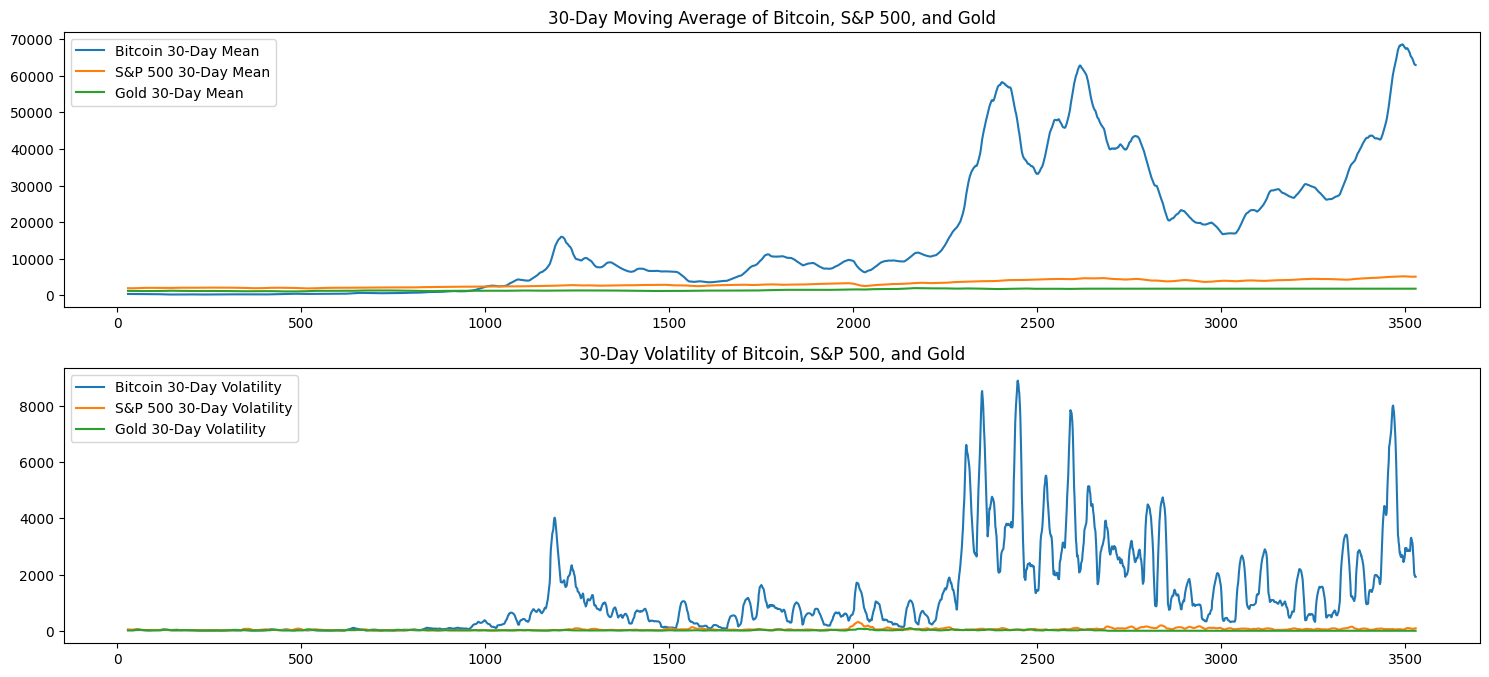

In [6]:
# Display the rolling statistics
# 30-day moving average and volatility for Bitcoin, S&P 500 and Gold
merged_data['Bitcoin_30D_Mean'] = merged_data['Bitcoin_Close'].rolling(window=30).mean()
merged_data['SP500_30D_Mean'] = merged_data['SP500_Close'].rolling(window=30).mean()
merged_data['Gold_30D_Mean'] = merged_data['USD (AM)'].rolling(window=30).mean()  
# Calculate the 30-day volatility (standard deviation) for Bitcoin, S&P 500, and Gold
merged_data['Bitcoin_30D_Vol'] = merged_data['Bitcoin_Close'].rolling(window=30).std()
merged_data['SP500_30D_Vol'] = merged_data['SP500_Close'].rolling(window=30).std()
merged_data['Gold_30D_Vol'] = merged_data['USD (AM)'].rolling(window=30).std() 

# Adding insights

# Plotting the 30-day moving averages and volatilities
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(merged_data['Bitcoin_30D_Mean'], label='Bitcoin 30-Day Mean')
plt.plot(merged_data['SP500_30D_Mean'], label='S&P 500 30-Day Mean')
plt.plot(merged_data['Gold_30D_Mean'], label='Gold 30-Day Mean')
plt.title('30-Day Moving Average of Bitcoin, S&P 500, and Gold')
plt.legend()

# Plotting the 30-day volatilities
plt.subplot(3, 1, 2)
plt.plot(merged_data['Bitcoin_30D_Vol'], label='Bitcoin 30-Day Volatility')
plt.plot(merged_data['SP500_30D_Vol'], label='S&P 500 30-Day Volatility')
plt.plot(merged_data['Gold_30D_Vol'], label='Gold 30-Day Volatility')
plt.title('30-Day Volatility of Bitcoin, S&P 500, and Gold')
plt.legend()

# Adjust layout to fit subplots nicely
plt.tight_layout()

# Display the plot
plt.show()

# Showcase the data using graphics.
* Plot the price (close) evolution over time
* Make a scatter plot of the Bitcoin price against the SP500 price and explain
* Plot the daily return histogram. We’ll define daily returns as 100*Log2[Price(t)/Price (t-1)]. The  histogram should use buckets of size 3.
* Comment to the Gaussian distribution.



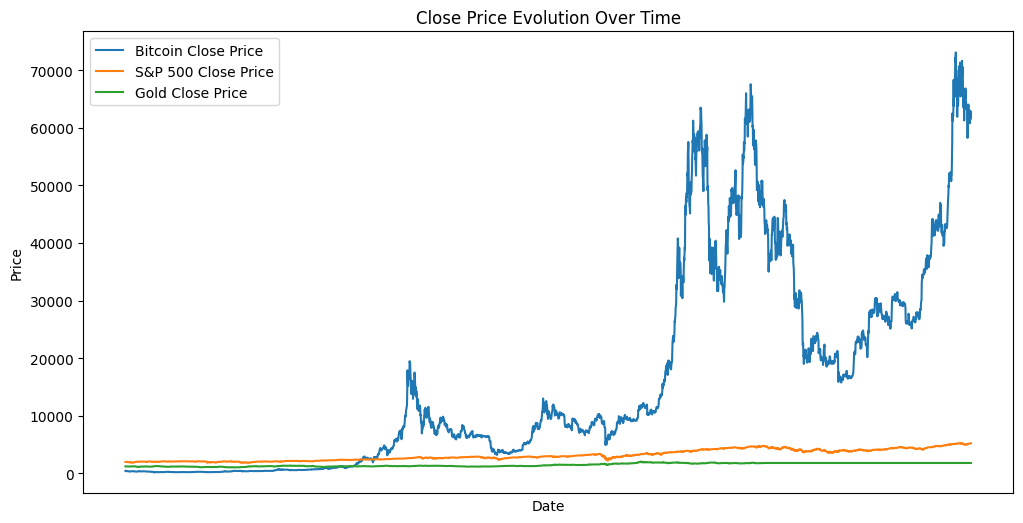

In [7]:
# Plot the price (close) evolution over time
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['Bitcoin_Close'], label='Bitcoin Close Price')
plt.plot(merged_data['Date'], merged_data['SP500_Close'], label='S&P 500 Close Price')
plt.plot(merged_data['Date'], merged_data['USD (AM)'], label='Gold Close Price')
plt.title('Close Price Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks([])
plt.show()



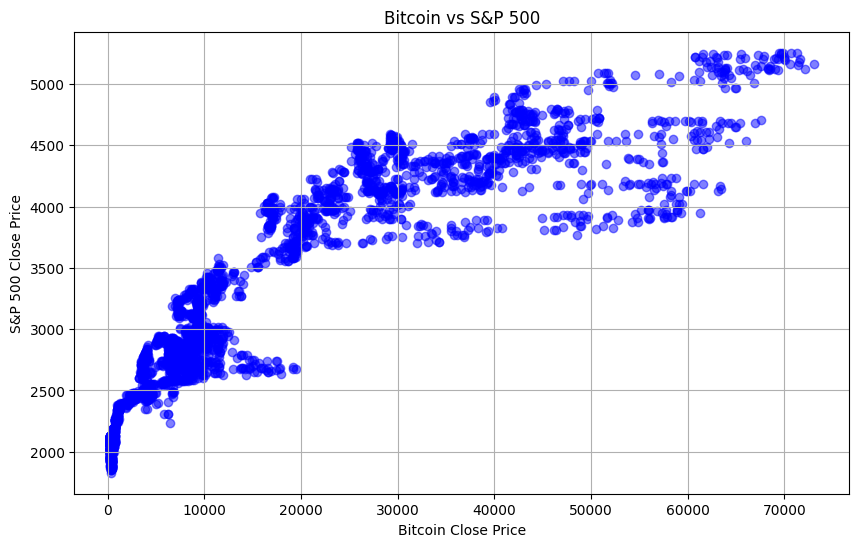

In [8]:
# Scatter plot of the Bitcoin price against the SP500 price
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Bitcoin_Close'], merged_data['SP500_Close'], color='blue', alpha=0.5)
plt.title('Bitcoin vs S&P 500')
plt.xlabel('Bitcoin Close Price')
plt.ylabel('S&P 500 Close Price')
plt.grid(True)
plt.show()

# Graphic explain:
The scatter plot provides a visual representation of the relationship between Bitcoin and S&P 500 closing prices, indicating a positive correlation. This suggests that there may be some degree of interdependence or similar influencing factors affecting both assets. 

In [9]:
# Daily return histogram
daily_returns = 100 * np.log2(merged_data['Bitcoin_Close'] / merged_data['Bitcoin_Close'].shift(1))
# Find the maximum and minimum values
max_return = daily_returns.max()
min_return = daily_returns.min()
# Print the maximum and minimum values
print("Maximun daily return:", max_return)
print("Minimun daily return:", min_return)



Maximun daily return: 32.47779990383427
Minimun daily return: -67.04639193141489


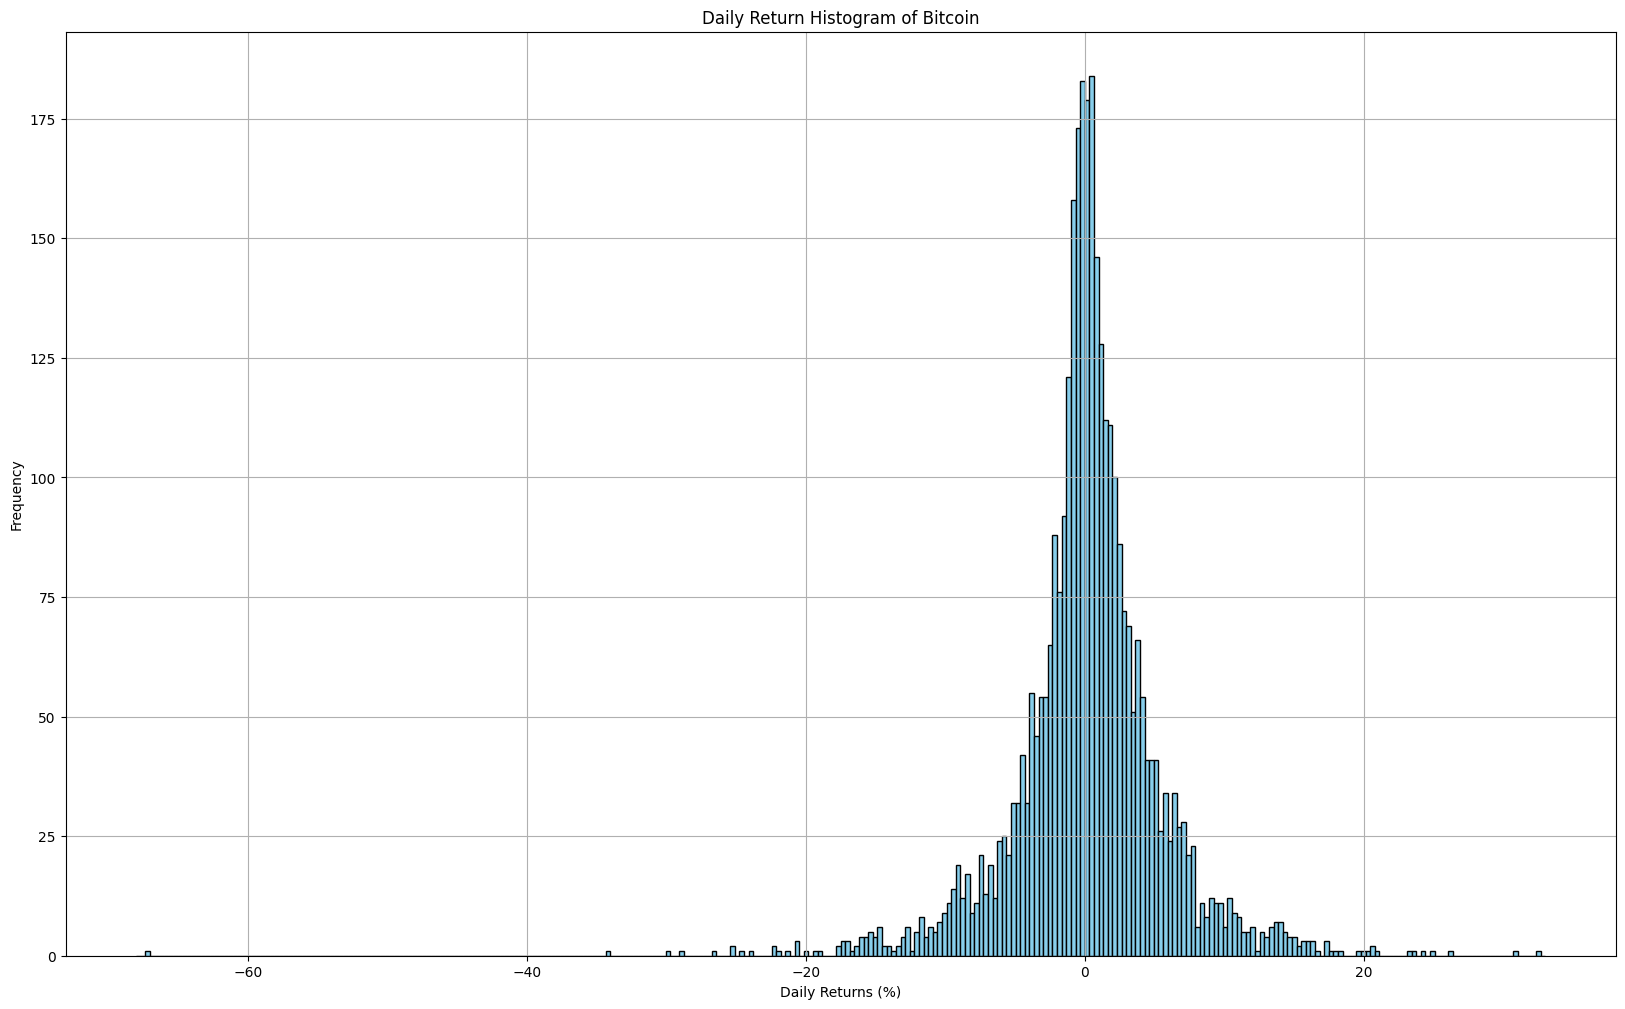

In [10]:
# Histogram of daily returns
plt.figure(figsize=(20, 12))
daily_returns = 100 * np.log2(merged_data['Bitcoin_Close'] / merged_data['Bitcoin_Close'].shift(1))
plt.hist(daily_returns, bins=np.arange(-68, 33, 0.33), color='skyblue', edgecolor='black')
plt.title('Daily Return Histogram of Bitcoin')
plt.xlabel('Daily Returns (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Explain
Bitcoin Daily Returns Histogram Analysis
- Apparent Distribution:
The distribution of daily returns appears to be centered near zero, which is common in financial data where most days do not feature extreme changes in price.
The shape of the distribution is leptokurtic, that is, it has thicker tails and a sharper peak than a normal distribution. This indicates a high occurrence of extreme events (very high or very low returns) compared to what would be expected in a normal distribution.
- Heavy Queues:
The presence of fat tails suggests that there is a higher than normal probability of large price changes, both positive and negative, occurring. This is typical of financial markets and is known as excessive kurtosis.
The extreme values in the tails of the histogram reflect the volatility and risk inherent in investing or trading Bitcoin.


In [11]:
# Calculation to determine the distribution
# Calculating descriptive statistics
mean_return = daily_returns.mean()
median_return = daily_returns.median()
std_dev_return = daily_returns.std()

# Printing the statistics
print(f"Mean of Daily Returns: {mean_return:.2f}%")
print(f"Median of Daily Returns: {median_return:.2f}%")
print(f"Standard Deviation of Daily Returns: {std_dev_return:.2f}%")




Mean of Daily Returns: 0.20%
Median of Daily Returns: 0.20%
Standard Deviation of Daily Returns: 5.34%


In [12]:
# Testing for normality
from scipy.stats import shapiro, normaltest

# Shapiro-Wilk test
stat, p = shapiro(daily_returns.dropna())
print('Shapiro-Wilk Test: Statistics=%.3f, p-value=%.3f' % (stat, p))

# D'Agostino's K^2 test
stat, p = normaltest(daily_returns.dropna())
print('D\'Agostino\'s K^2 Test: Statistics=%.3f, p-value=%.3f' % (stat, p))
from scipy.stats import kurtosis, skew

# Calculating kurtosis and skewness
kurt = kurtosis(daily_returns.dropna())
skewness = skew(daily_returns.dropna())
print('Kurtosis: %f' % kurt)
print('Skewness: %f' % skewness)

Shapiro-Wilk Test: Statistics=0.904, p-value=0.000
D'Agostino's K^2 Test: Statistics=935.005, p-value=0.000
Kurtosis: 11.301219
Skewness: -0.750316


# Comment:
Results analysis:
  
  1- Shapiro-Wilk test:
 - Statistical: 0.904. A value lower than 1 indicates some deviation from normality.
 - p-value: 0.000. A p-value significantly less than 0.05 rejects the null hypothesis that the sample comes from a normal distribution.

 2- D'Agostino and Pearson test:
 - Statistician: 933,655. A very high value indicates strong deviations from normality.
 - p-value: 0.000. Similarly, a p-value of 0 rejects the null hypothesis of normality.

 3- Kurtosis:
 - Value: 11.297329. A kurtosis significantly greater than 0 (kurtosis of a normal distribution is 0) suggests heavier tails and a sharper peak than a normal distribution. This is a sign of the presence of more frequent extreme events than the normal distribution would predict.

 4- Asymmetry:
 - Value: -0.750446. A negative skew indicates that the data distribution is skewed to the left, meaning that there is a longer tail on the left side of the peak of the distribution.



### Generate synthetic data. Generating new data from other PREVIOUS data points/features is common in finance. 


In [13]:
# Calculate indicators
def calculate_indicators(hist, coin_name):
    hist[f'{coin_name}_price_amplitude'] = 100 * ((hist[f'{coin_name}_High'] / hist[f'{coin_name}_Low']) - 1)
    hist[f'{coin_name}_7_day_return'] = np.log2(hist[f'{coin_name}_Close'] / hist[f'{coin_name}_Close'].shift(7))
    hist[f'{coin_name}_SMA_7'] = hist[f'{coin_name}_Close'].rolling(window=7).mean()
    hist[f'{coin_name}_SMA_14'] = hist[f'{coin_name}_Close'].rolling(window=14).mean()
    hist[f'{coin_name}_SMA_CROSS'] = np.where(hist[f'{coin_name}_SMA_7'] > hist[f'{coin_name}_SMA_14'], 1, 0)

In [14]:
# Function call 
calculate_indicators(merged_data,'Bitcoin')
calculate_indicators(merged_data,'SP500')



In [15]:
# Dataframe result
merged_data



Date  Bitcoin_Open  Bitcoin_High   Bitcoin_Low  Bitcoin_Close  \
0     17/09/14    465.864014    468.174011    452.421997     457.334015   
1     18/09/14    456.859985    456.859985    413.104004     424.440002   
2     19/09/14    424.102997    427.834991    384.532013     394.795990   
3     20/09/14    394.673004    423.295990    389.882996     408.903992   
4     21/09/14    408.084991    412.425995    393.181000     398.821014   
...        ...           ...           ...           ...            ...   
3524  11/05/24  60793.355469  61451.152344  60492.625000   60793.710938   
3525  12/05/24  60793.503906  61818.156250  60632.601562   61448.394531   
3526  13/05/24  61451.218750  63422.660156  60769.839844   62901.449219   
3527  14/05/24  62900.773438  63092.125000  61123.765625   61552.789062   
3528  15/05/24  61549.578125  62896.226562  61358.839844   62631.992188   

      Bitcoin_Volume  USD (AM)  USD (PM)  GBP (AM)  GBP (PM)  ...  \
0           21056800    1236.5   1236.00   758.729   756.519  ...   
1           34483200    1223.0   1220.50   749.985   744.571  ...   
2           37919700    1222.5   1219.75   745.381   746.344  ...   
3           36863600    1222.5   1219.75   745.381   746.344  ...   
4           26580100    1222.5   1219.75   745.381   746.344  ...   
...              ...       ...       ...       ...       ...  ...   
3524     13842272968    1820.1   1805.85  1347.060  1336.510  ...   
3525     13800459405    1820.1   1805.85  1347.060  1336.510  ...   
3526     27889181179    1820.1   1805.85  1347.060  1336.510  ...   
3527     28186271527    1820.1   1805.85  1347.060  1336.510  ...   
3528     25921966080    1820.1   1805.85  1347.060  1336.510  ...   

      Bitcoin_price_amplitude  Bitcoin_7_day_return  Bitcoin_SMA_7  \
0                    3.481708                   NaN            NaN   
1                   10.592001                   NaN            NaN   
2                   11.261215                   NaN            NaN   
3                    8.570006                   NaN            NaN   
4                    4.894691                   NaN            NaN   
...                       ...                   ...            ...   
3524                 1.584536             -0.071701   62193.184152   
3525                 1.955309             -0.059398   61824.221540   
3526                 4.365357             -0.005962   61787.007254   
3527                 3.220285             -0.018214   61675.289062   
3528                 2.505567              0.033652   61881.582031   

      Bitcoin_SMA_14  Bitcoin_SMA_CROSS  SP500_price_amplitude  \
0                NaN                  0               0.875435   
1                NaN                  0               0.462791   
2                NaN                  0               0.631422   
3                NaN                  0               0.000000   
4                NaN                  0               0.000000   
...              ...                ...                    ...   
3524    61935.875000                  1               0.000000   
3525    61816.958147                  1               0.000000   
3526    61749.838728                  1               0.500841   
3527    61815.262556                  0               0.620741   
3528    62127.975446                  0               0.000000   

      SP500_7_day_return  SP500_SMA_7  SP500_SMA_14  SP500_SMA_CROSS  
0                    NaN          NaN           NaN                0  
1                    NaN          NaN           NaN                0  
2                    NaN          NaN           NaN                0  
3                    NaN          NaN           NaN                0  
4                    NaN          NaN           NaN                0  
...                  ...          ...           ...              ...  
3524            0.026453  5191.905831   5138.095075                1  
3525            0.026453  5205.461565   5146.860805                1  
3526   

### Create the target Variable. Its name is price-next-day. It has the value of the NEXT Bitcoin price. It is the price we’re trying to predict.
 At this point, you should have:
 * A dataset of 10 features 
 * One index (the Date).
 * One target Variable


In [16]:
# Dataframe
bitcoin = merged_data[['Date','Bitcoin_Open','Bitcoin_High','Bitcoin_Low','Bitcoin_Close','Bitcoin_Volume','Bitcoin_price_amplitude','Bitcoin_7_day_return','Bitcoin_SMA_7','Bitcoin_SMA_14','Bitcoin_SMA_CROSS']]
bitcoin.set_index('Date', inplace=True)
bitcoin_cleaned = bitcoin.dropna()

In [17]:
# Target variable
bitcoin_cleaned['price_next_day'] = bitcoin_cleaned['Bitcoin_Close'].shift(-1)

C:\Users\Guim\AppData\Local\Temp\ipykernel_3296\4108964662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_cleaned['price_next_day'] = bitcoin_cleaned['Bitcoin_Close'].shift(-1)


In [18]:
# Dataframe result
bitcoin_cleaned


Bitcoin_Open  Bitcoin_High   Bitcoin_Low  Bitcoin_Close  \
Date                                                                
30/09/14    376.088013    390.976990    373.442993     386.944000   
01/10/14    387.427002    391.378998    380.779999     383.614990   
02/10/14    383.988007    385.497009    372.946014     375.071991   
03/10/14    375.181000    377.695007    357.859009     359.511993   
04/10/14    359.891998    364.487000    325.885986     328.865997   
...                ...           ...           ...            ...   
11/05/24  60793.355469  61451.152344  60492.625000   60793.710938   
12/05/24  60793.503906  61818.156250  60632.601562   61448.394531   
13/05/24  61451.218750  63422.660156  60769.839844   62901.449219   
14/05/24  62900.773438  63092.125000  61123.765625   61552.789062   
15/05/24  61549.578125  62896.226562  61358.839844   62631.992188   

          Bitcoin_Volume  Bitcoin_price_amplitude  Bitcoin_7_day_return  \
Date                                                                      
30/09/14        34707300                 4.695227             -0.171512   
01/10/14        26229400                 2.783497             -0.141698   
02/10/14        21777700                 3.365365             -0.133984   
03/10/14        30901200                 5.542965             -0.169832   
04/10/14        47236500                11.844944             -0.280768   
...                  ...                      ...                   ...   
11/05/24     13842272968                 1.584536             -0.071701   
12/05/24     13800459405                 1.955309             -0.059398   
13/05/24     27889181179                 4.365357             -0.005962   
14/05/24     28186271527                 3.220285             -0.018214   
15/05/24     25921966080                 2.505567              0.033652   

          Bitcoin_SMA_7  Bitcoin_SMA_14  Bitcoin_SMA_CROSS  price_next_day  
Date                                                                        
30/09/14     396.902283      407.182428                  0      383.614990  
01/10/14     391.246569      401.916783                  0      375.071991  
02/10/14     386.031996      398.390496                  0      359.511993  
03/10/14     379.615853      395.870211                  0      328.865997  
04/10/14     369.522426      390.153211                  0      320.510010  
...                 ...             ...                ...             ...  
11/05/24   62193.184152    61935.875000                  1    61448.394531  
12/05/24   61824.221540    61816.958147                  1    62901.449219  
13/05/24   61787.007254    61749.838728                  1    61552.789062  
14/05/24   61675.289062    61815.262556                  0    62631.992188  
15/05/24   61881.582031    62127.975446                  0             NaN  

[3516 rows x 11 columns]

# 2. Data prediction
## Linear model fitted by minimizing a regularized empirical loss with SGD

In [19]:
# Optionally, verify the number of rows removed
print("Original rows:", len(bitcoin))
print("Rows after removing NaN:", len(bitcoin_cleaned))


Original rows: 3529
Rows after removing NaN: 3516


In [20]:
# Defining the function
# Divide each 500-day window into train (80%) and test (20%) dataset.
def rolling_window_split(data, window_size, test_ratio=0.2):
    """
    Splits the data into overlapping rolling windows.

    Parameters:
    - data (pd.DataFrame): The time series data to split, indexed by datetime.
    - window_size (int): Total number of rows per window.
    - test_ratio (float): Proportion of each window to use as the test set.

    Returns:
    - time_series (list): List of dictionaries containing training and test datasets for each window.
    """
    time_series = []
    test_size = int(window_size * test_ratio)
    train_size = window_size-test_size
    num_windows = int((len(data)-window_size)/test_size)
 
    for i in range(num_windows + 1):
        start_idx = i * test_size
        end_idx = start_idx + window_size
        train_end_idx = end_idx - test_size

        train_set = data.iloc[start_idx:train_end_idx]
        test_set = data.iloc[train_end_idx:end_idx]

        time_series.append({'train': train_set, 'test': test_set})

    return time_series



In [21]:

window_size = 500  # Total window size
test_ratio = 0.2  # 20% test
time_series = rolling_window_split(bitcoin_cleaned, window_size, test_ratio)
time_series

[{'train':           Bitcoin_Open  Bitcoin_High  Bitcoin_Low  Bitcoin_Close  \
  Date                                                               
  30/09/14    376.088013    390.976990   373.442993     386.944000   
  01/10/14    387.427002    391.378998   380.779999     383.614990   
  02/10/14    383.988007    385.497009   372.946014     375.071991   
  03/10/14    375.181000    377.695007   357.859009     359.511993   
  04/10/14    359.891998    364.487000   325.885986     328.865997   
  ...                ...           ...          ...            ...   
  30/10/15    313.942993    334.169006   313.940002     328.015015   
  31/10/15    328.511993    332.777008   309.251007     314.165985   
  01/11/15    315.005005    327.471985   311.881012     325.431000   
  02/11/15    325.941986    365.359985   323.209015     361.188995   
  03/11/15    361.872986    417.899994   357.647003     403.416992   
  
            Bitcoin_Volume  Bitcoin_price_amplitude  Bitcoin_7_day_return  \
 

In [22]:

# MAPE definition 
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the mean absolute percentage error between the true and predicted values.

    Parameters:
    - y_true (array-like): The true target values.
    - y_pred (array-like): The predicted target values.

    Returns:
    - mape (float): Mean absolute percentage error.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Window 0 MAE: 3.445749175639255e+24, Window RMSE: 3.946976172136862e+24, Window MAPE: 8.774350041496744e+23


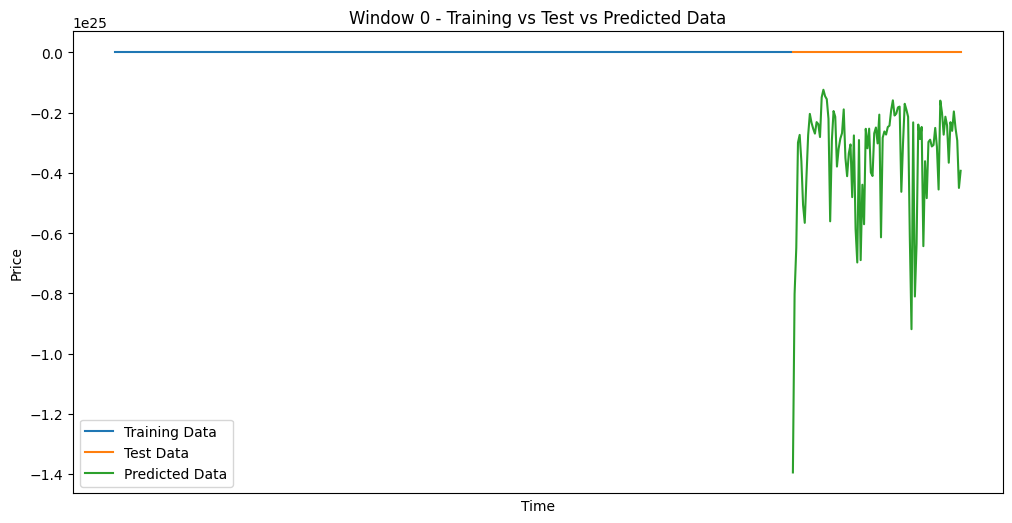

Window 1 MAE: 7.279209844136525e+23, Window RMSE: 7.529476034664769e+23, Window MAPE: 1.698414284026499e+23


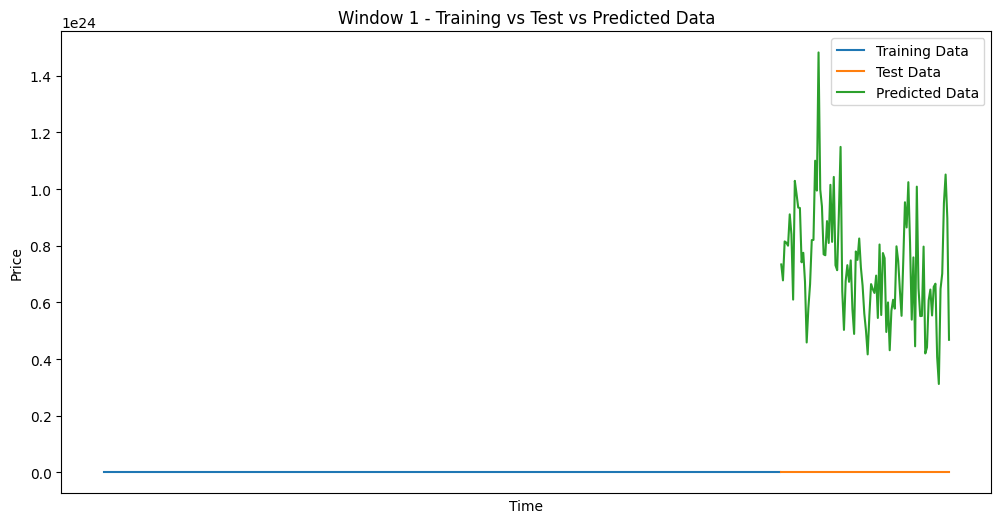

Window 2 MAE: 4.275792441164427e+24, Window RMSE: 4.964675491641883e+24, Window MAPE: 6.848297164778362e+23


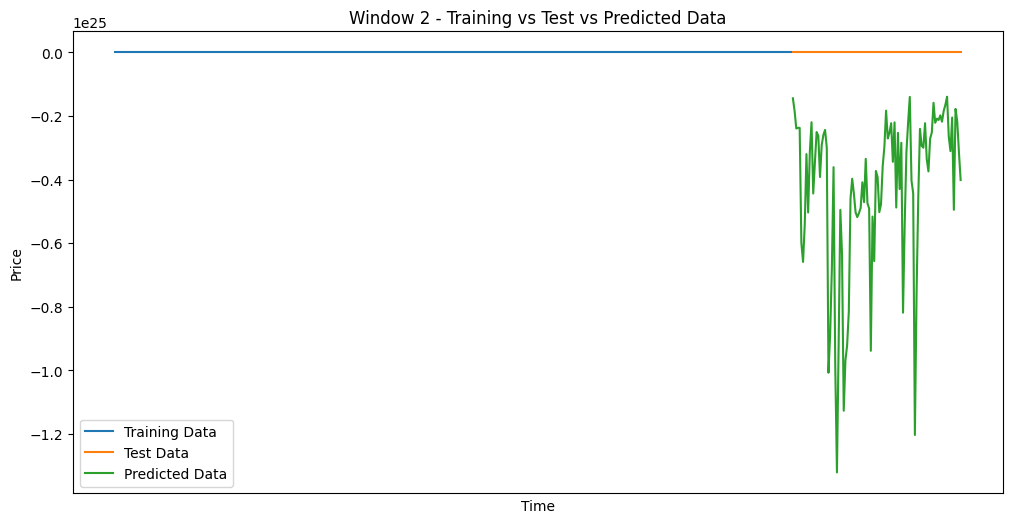

Window 3 MAE: 3.799773588272886e+24, Window RMSE: 4.051198886820817e+24, Window MAPE: 5.666327447163377e+23


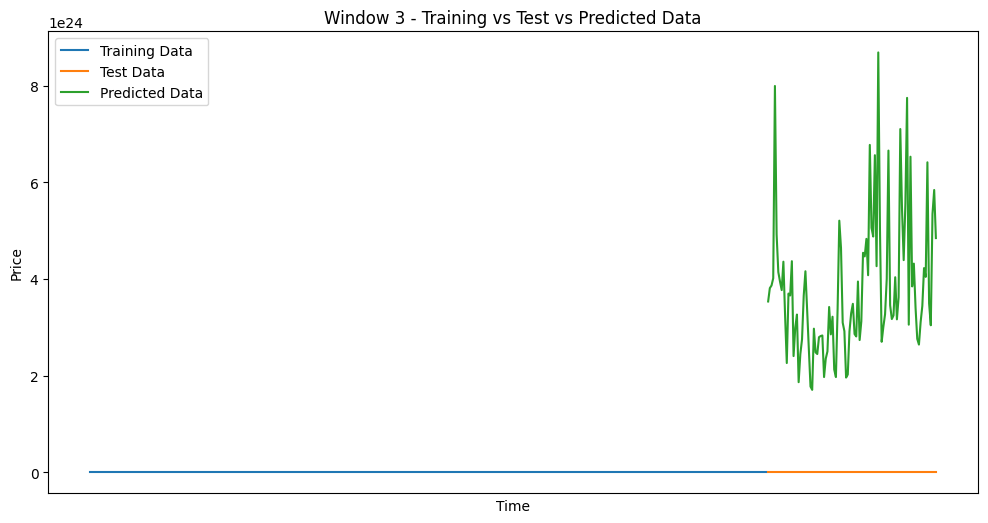

Window 4 MAE: 1.6665556229972173e+25, Window RMSE: 2.009910252647501e+25, Window MAPE: 1.6517819642819287e+24


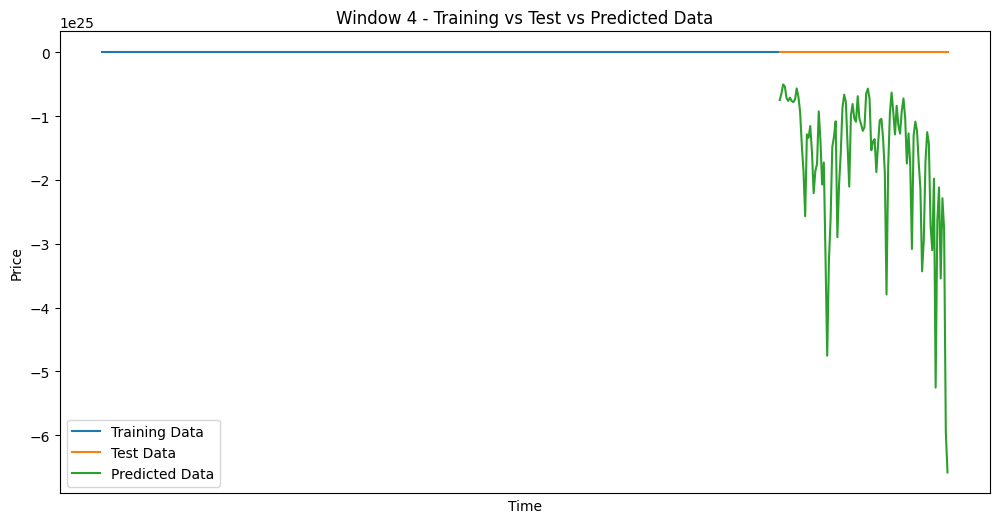

Window 5 MAE: 7.552209916686398e+25, Window RMSE: 9.126736073399107e+25, Window MAPE: 3.8757066750480267e+24


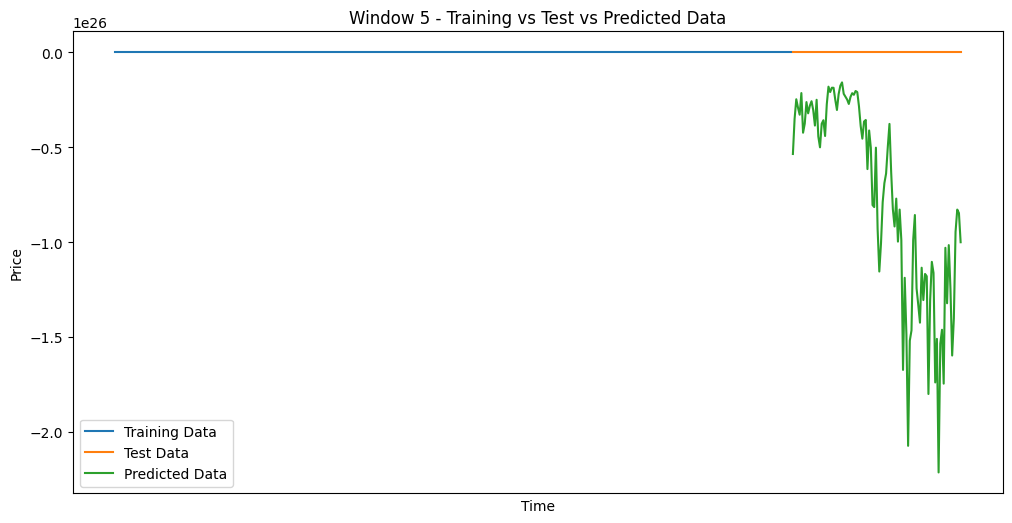

Window 6 MAE: 3.789078122098775e+26, Window RMSE: 4.156952567787236e+26, Window MAPE: 1.0779721942317093e+25


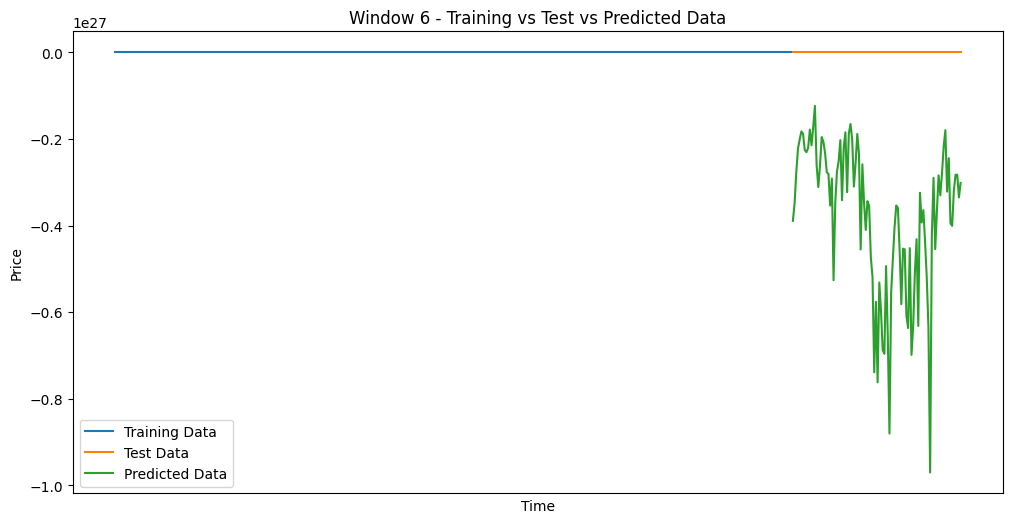

Window 7 MAE: 1.77897549935841e+27, Window RMSE: 2.2699344235655608e+27, Window MAPE: 1.4807106239004547e+25


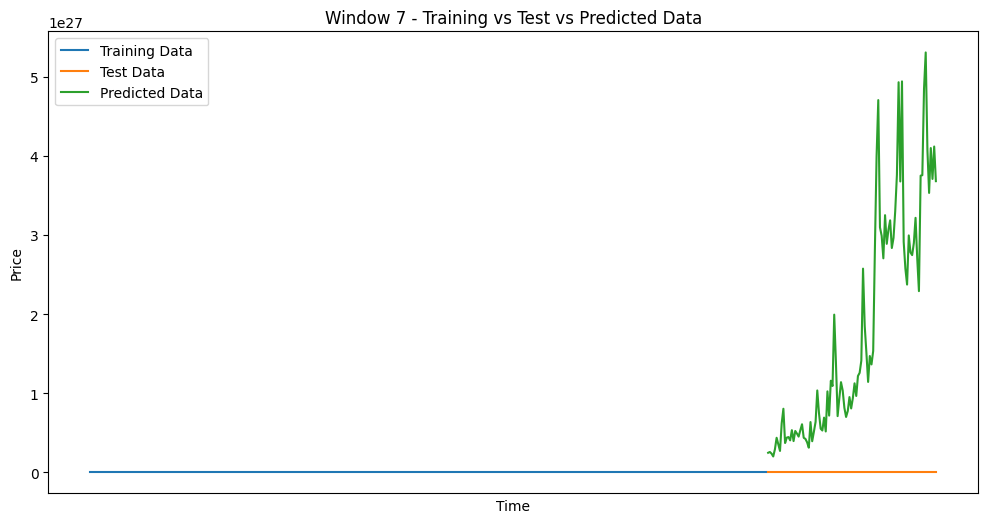

Window 8 MAE: 1.7276435473367972e+28, Window RMSE: 1.8384702201690834e+28, Window MAPE: 1.8359983992089746e+26


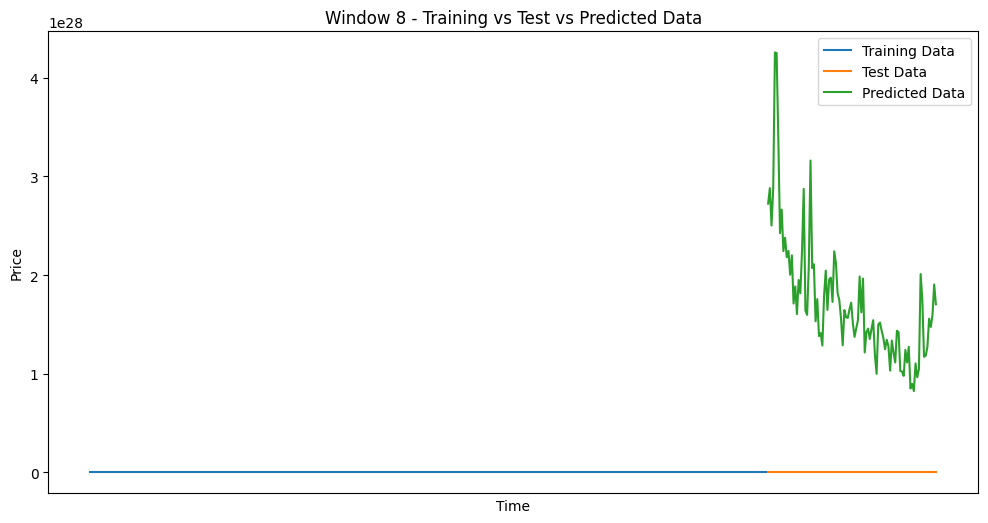

Window 9 MAE: 5.527355568233554e+28, Window RMSE: 5.8017205372014815e+28, Window MAPE: 7.150364476389833e+26


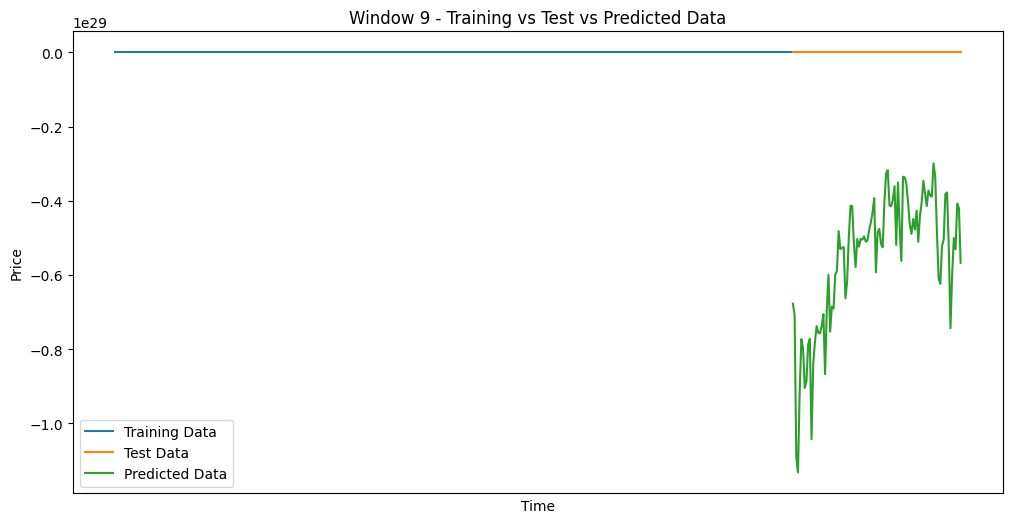

Window 10 MAE: 6.490837298077644e+27, Window RMSE: 6.584580369723779e+27, Window MAPE: 9.866722728156112e+25


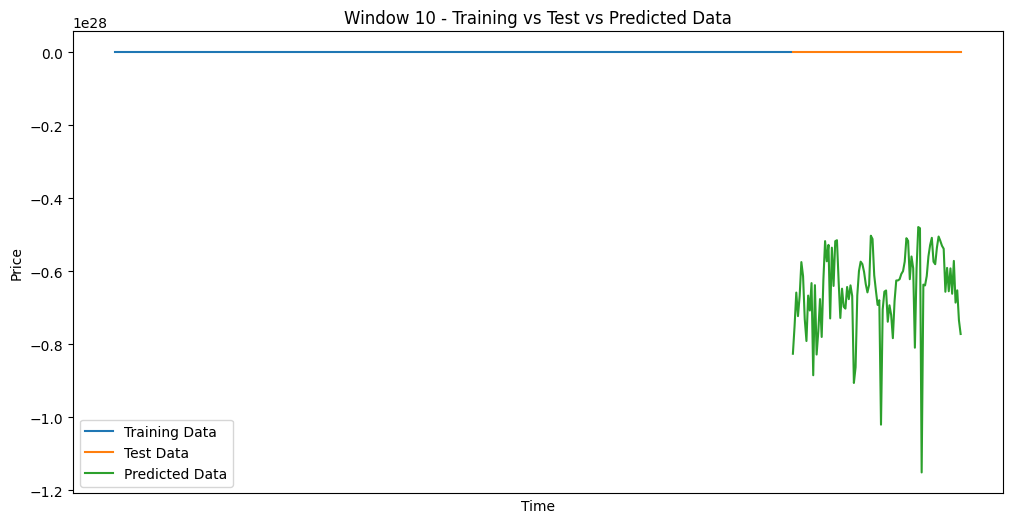

Window 11 MAE: 8.376289308365124e+27, Window RMSE: 8.508223467094342e+27, Window MAPE: 2.1639366791747545e+26


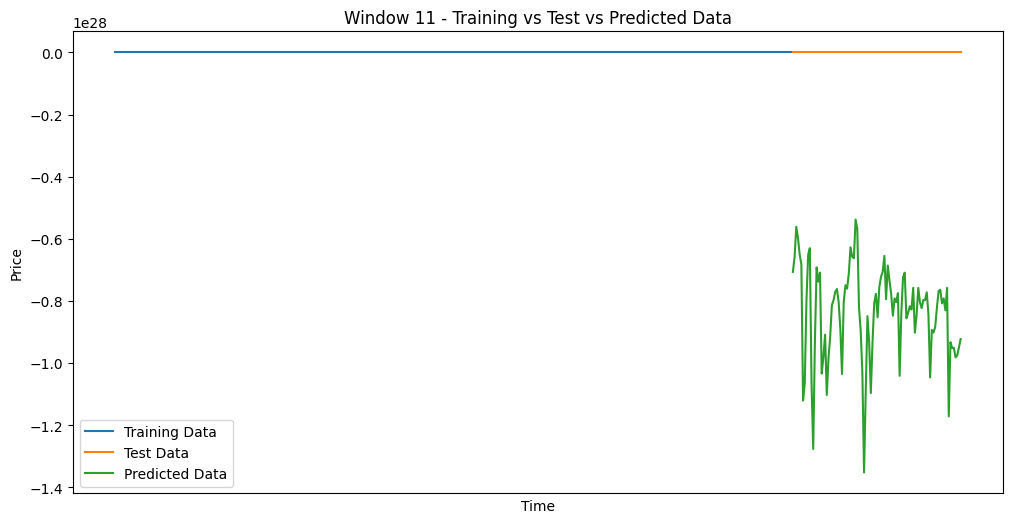

Window 12 MAE: 1.767428548941776e+28, Window RMSE: 1.935218733633512e+28, Window MAPE: 3.302304400059213e+26


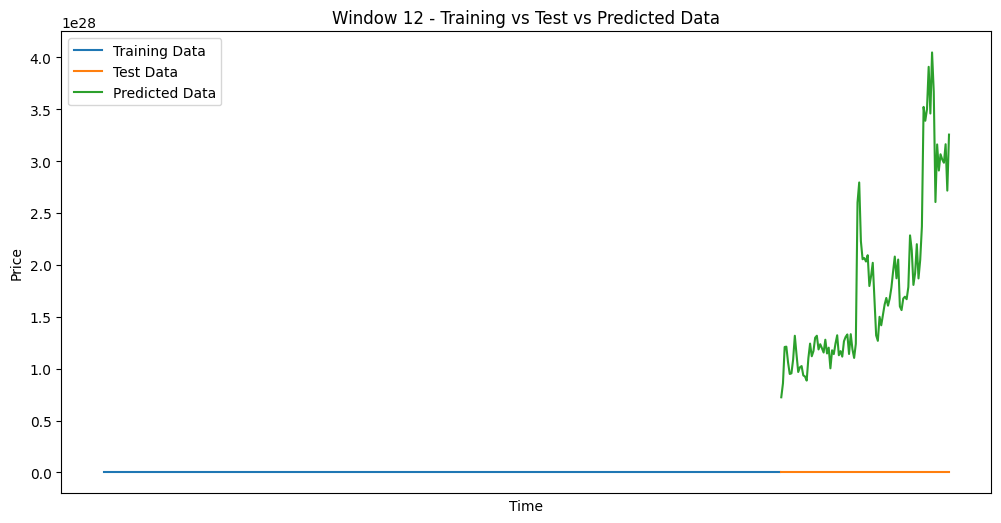

Window 13 MAE: 1.542400513971779e+29, Window RMSE: 1.6046532646976184e+29, Window MAPE: 1.5247699097292187e+27


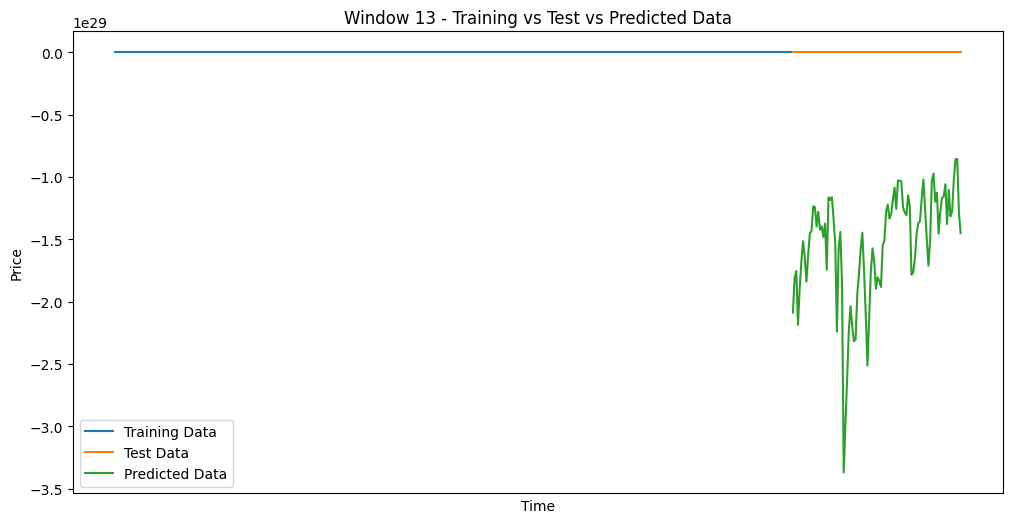

Window 14 MAE: 1.1187577814714725e+29, Window RMSE: 1.1697789189807745e+29, Window MAPE: 1.321317915423914e+27


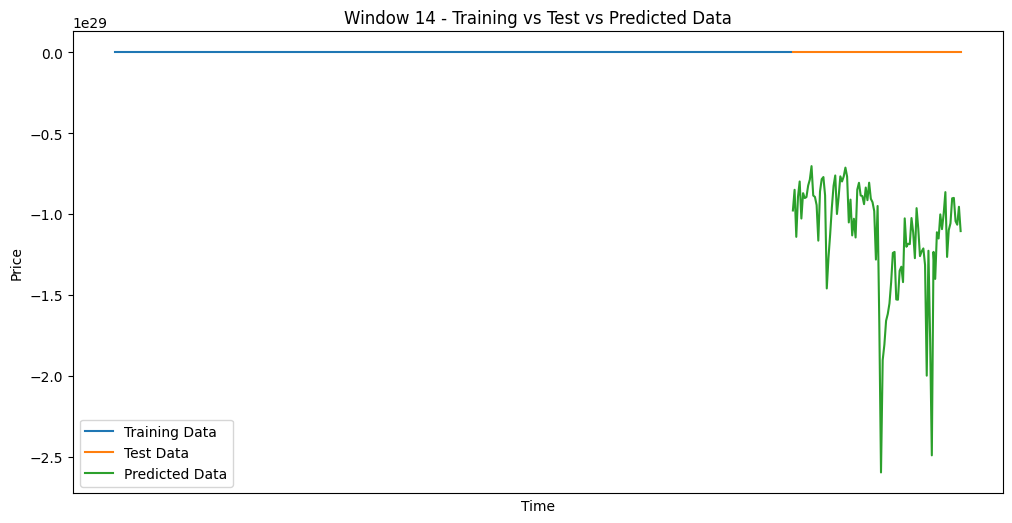

Window 15 MAE: 1.5671927922760163e+29, Window RMSE: 1.6425723726486193e+29, Window MAPE: 1.9642745292748473e+27


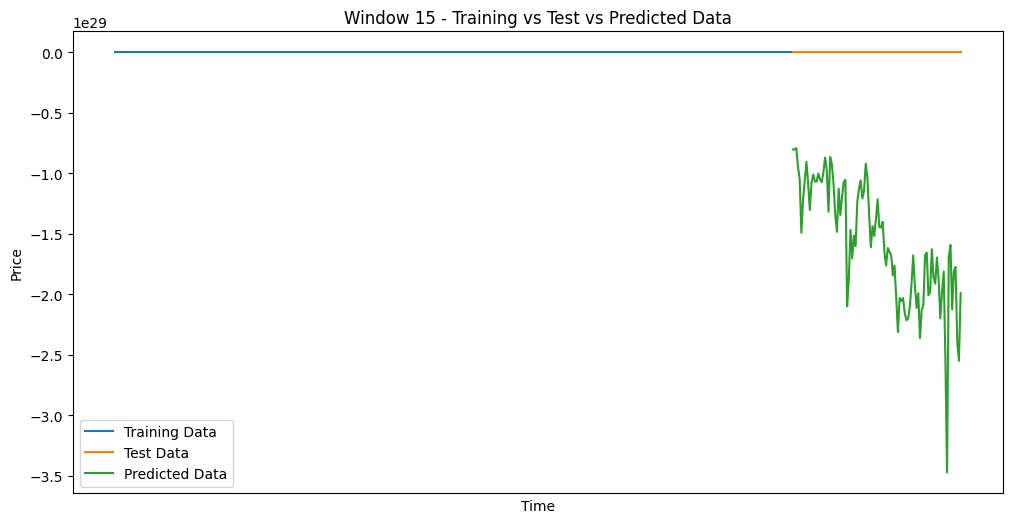

Window 16 MAE: 2.5718845336815056e+29, Window RMSE: 2.7077551230143766e+29, Window MAPE: 3.143134460264511e+27


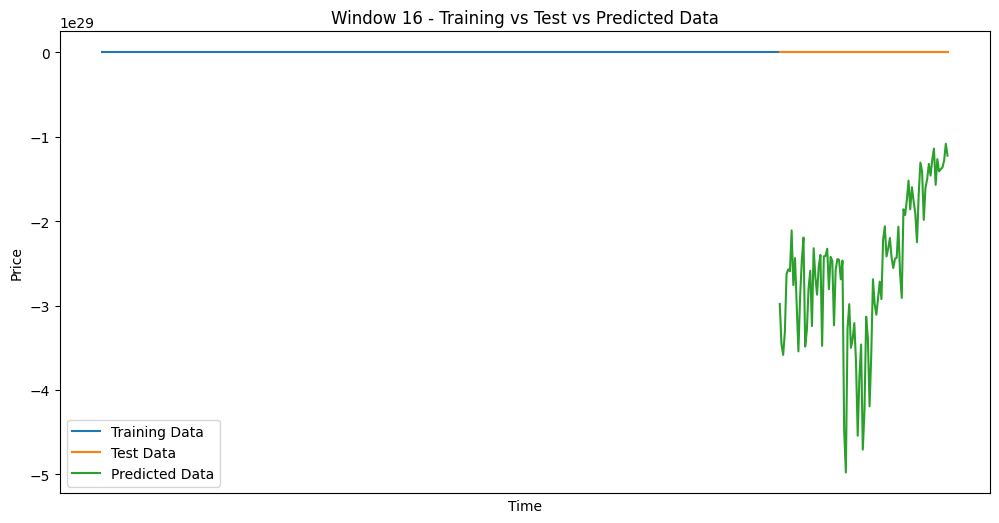

Window 17 MAE: 3.284537711190887e+29, Window RMSE: 3.57057721891436e+29, Window MAPE: 3.0772877665932145e+27


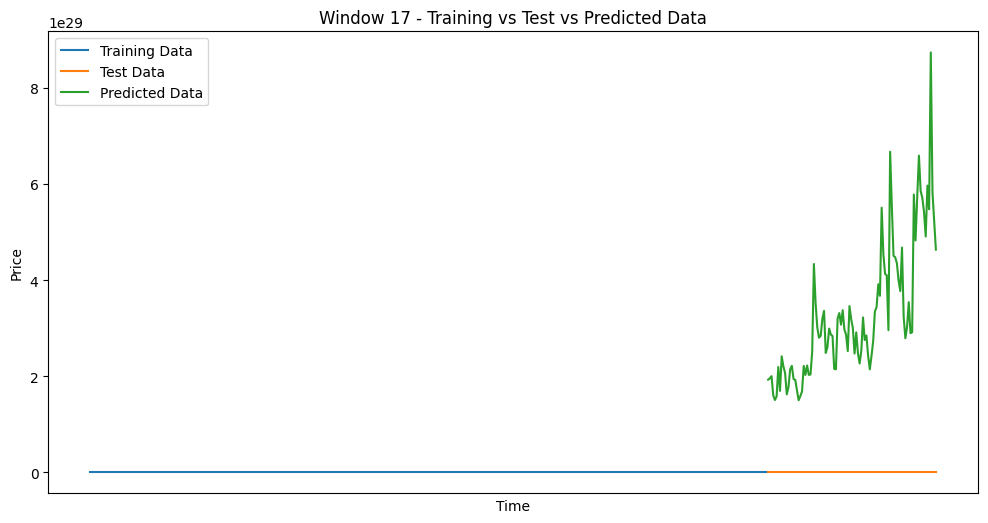

Window 18 MAE: 4.106738826616608e+28, Window RMSE: 4.5014476676117685e+28, Window MAPE: 2.0571787540083102e+26


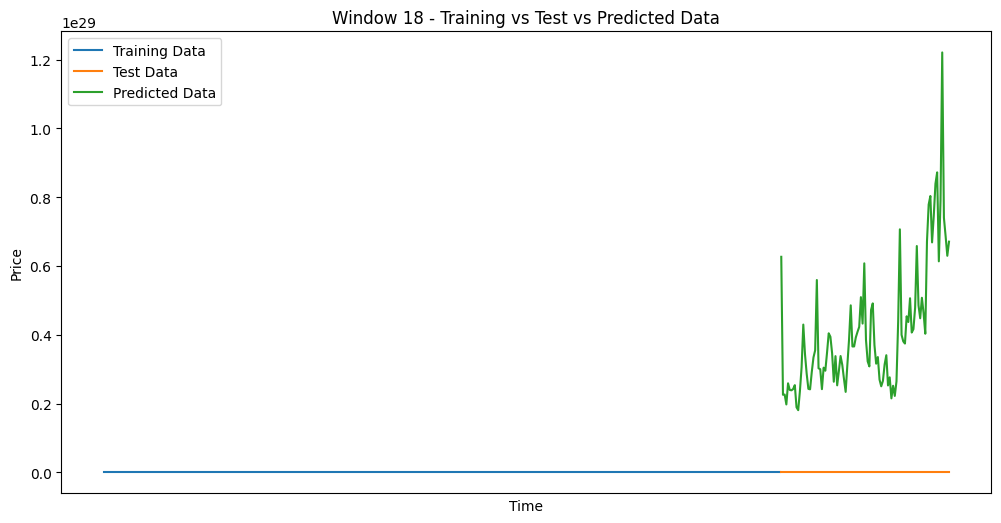

Window 19 MAE: 1.710781185942e+30, Window RMSE: 1.904146461754418e+30, Window MAPE: 3.5973235976121416e+27


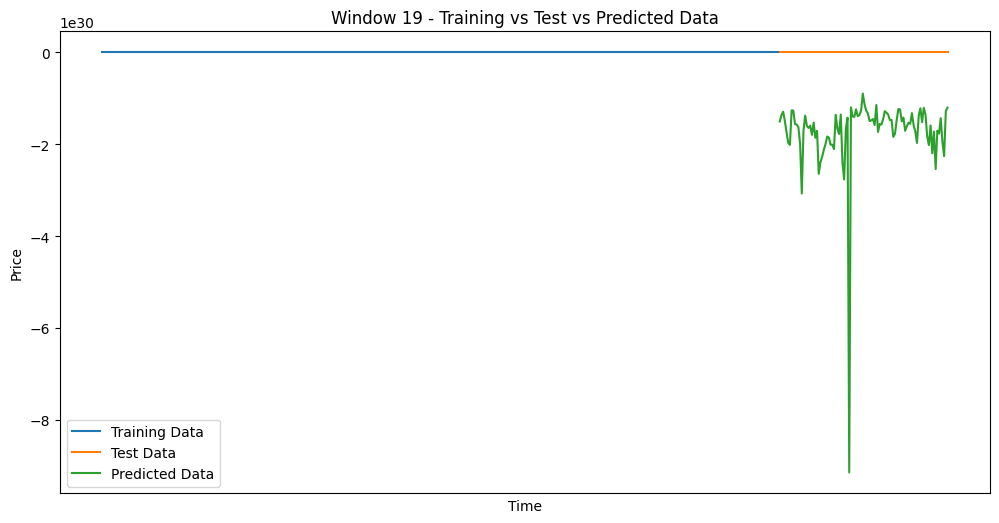

Window 20 MAE: 8.159144668664452e+29, Window RMSE: 8.937686237916049e+29, Window MAPE: 2.0402282394143644e+27


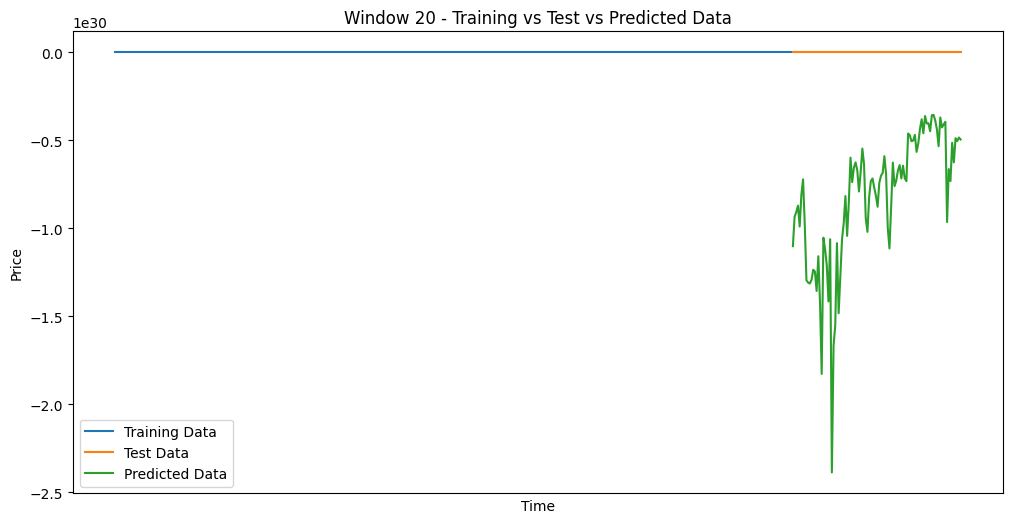

Window 21 MAE: 5.2434479515485395e+29, Window RMSE: 5.3294051755406684e+29, Window MAPE: 1.0267371673615809e+27


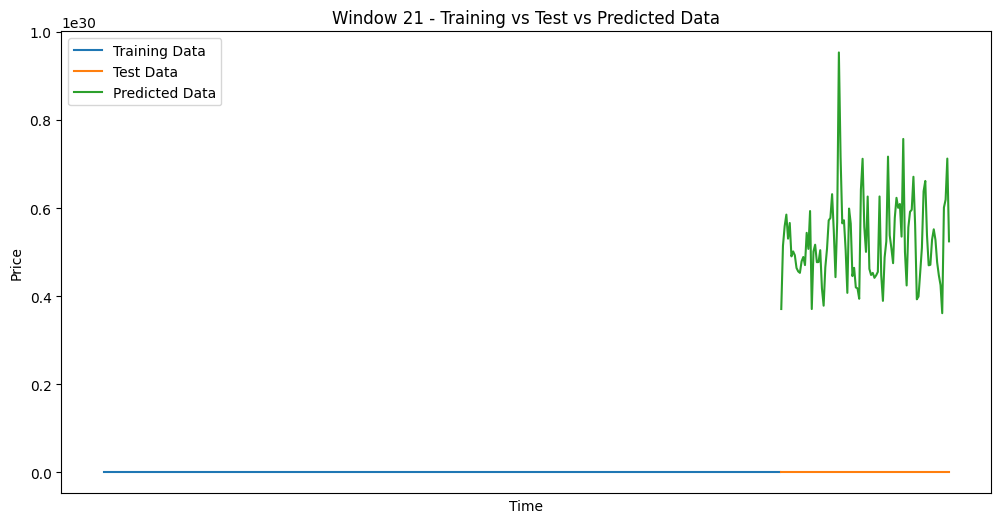

Window 22 MAE: 2.6972539205678105e+30, Window RMSE: 2.8417270044101395e+30, Window MAPE: 5.803405388319942e+27


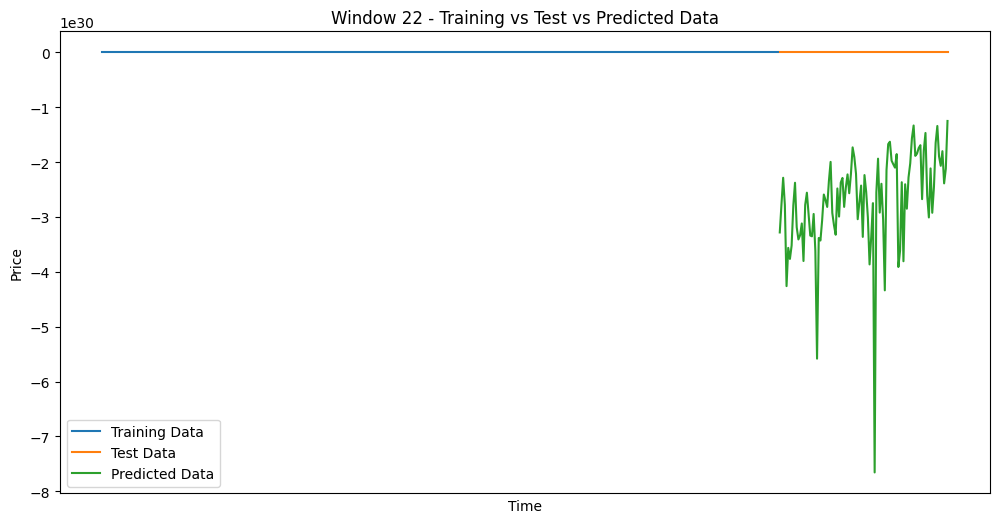

Window 23 MAE: 9.848963096099384e+29, Window RMSE: 1.0383305223430219e+30, Window MAPE: 2.6689156139299065e+27


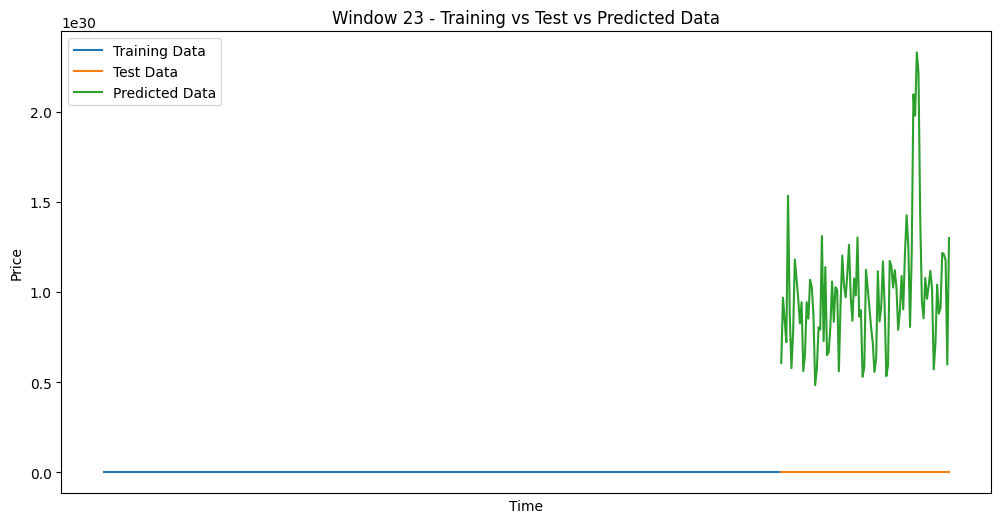

Window 24 MAE: 3.69170432346177e+29, Window RMSE: 3.8388015769353566e+29, Window MAPE: 1.6668982118408555e+27


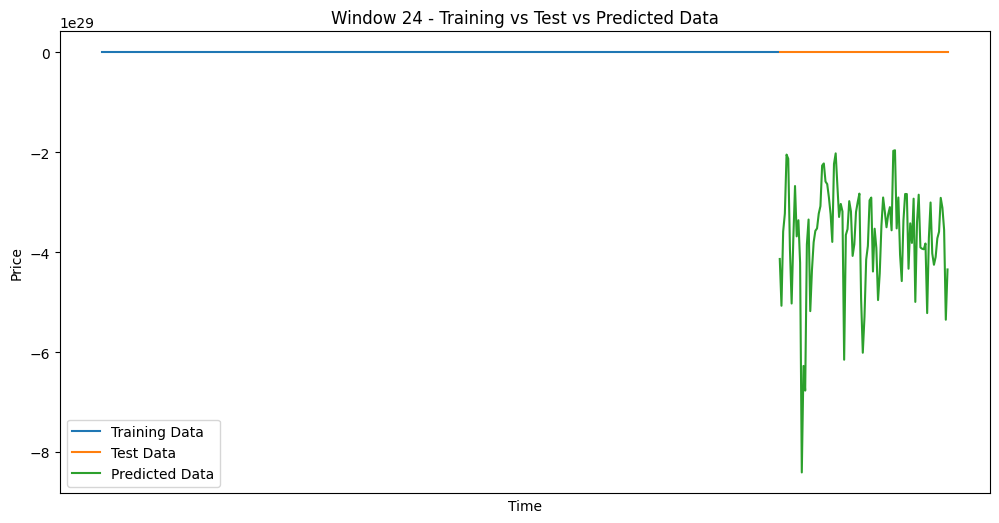

Window 25 MAE: 7.575625324028396e+29, Window RMSE: 8.450510542657033e+29, Window MAPE: 4.0625707028469085e+27


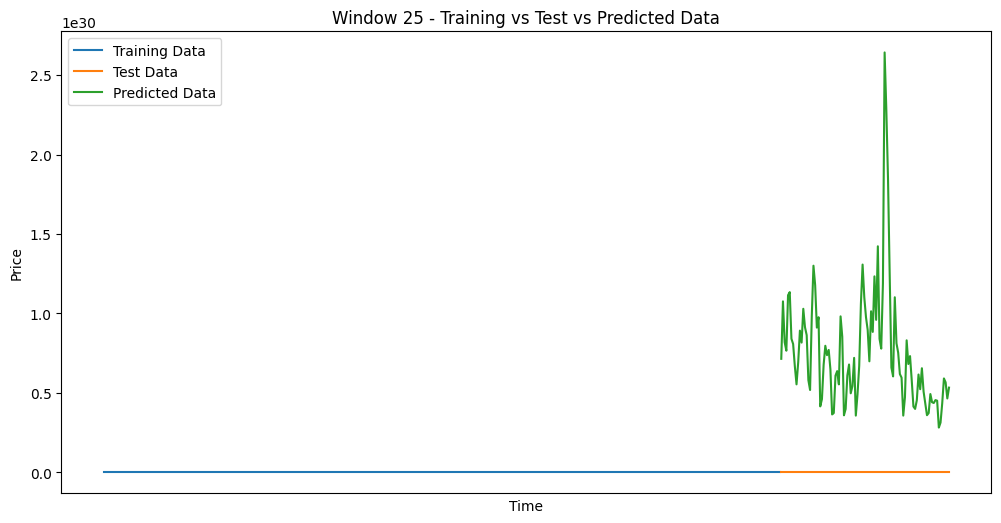

Window 26 MAE: 3.3145884597136395e+29, Window RMSE: 3.5719775686334245e+29, Window MAPE: 1.494402079767127e+27


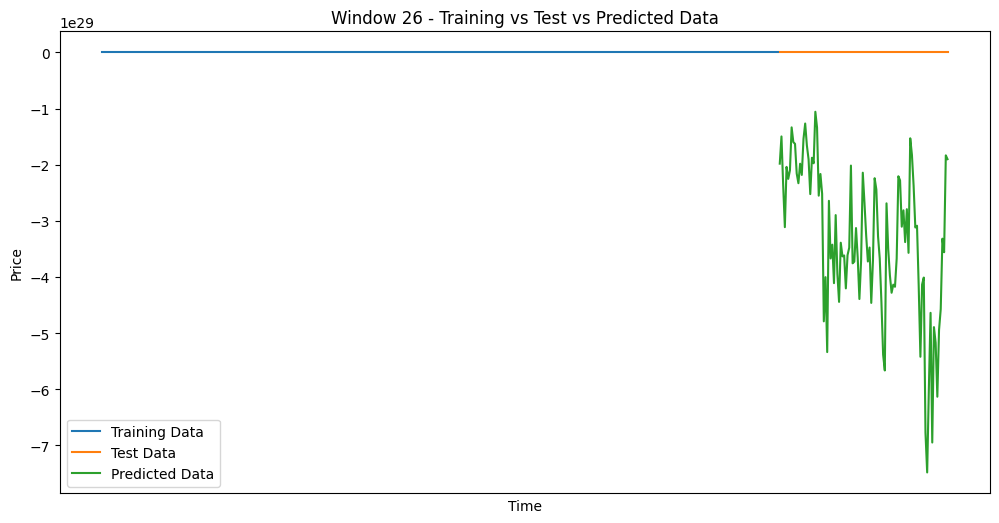

Window 27 MAE: 7.322562035676761e+28, Window RMSE: 7.663159391305164e+28, Window MAPE: 2.5943961325928376e+26


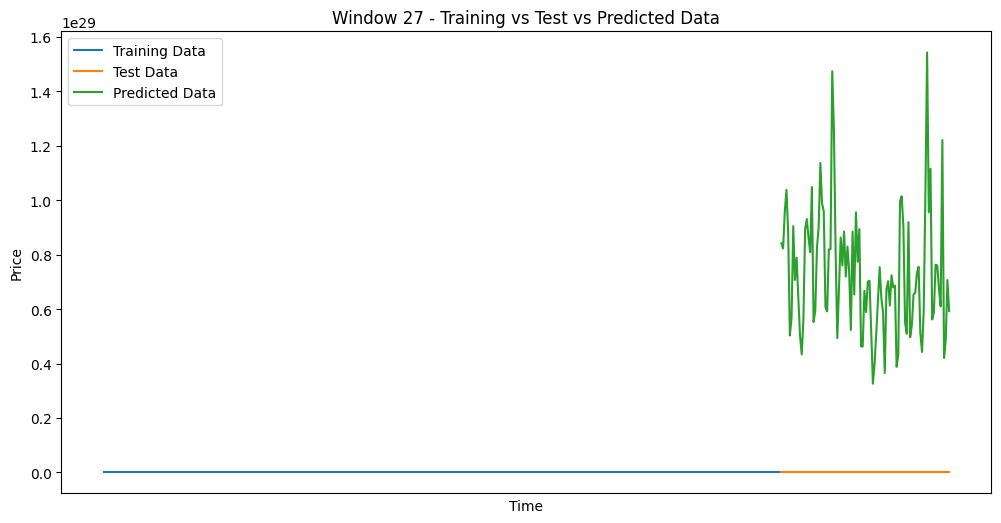

Window 28 MAE: 1.9895047496502238e+29, Window RMSE: 2.1258868033345532e+29, Window MAPE: 7.159997840472582e+26


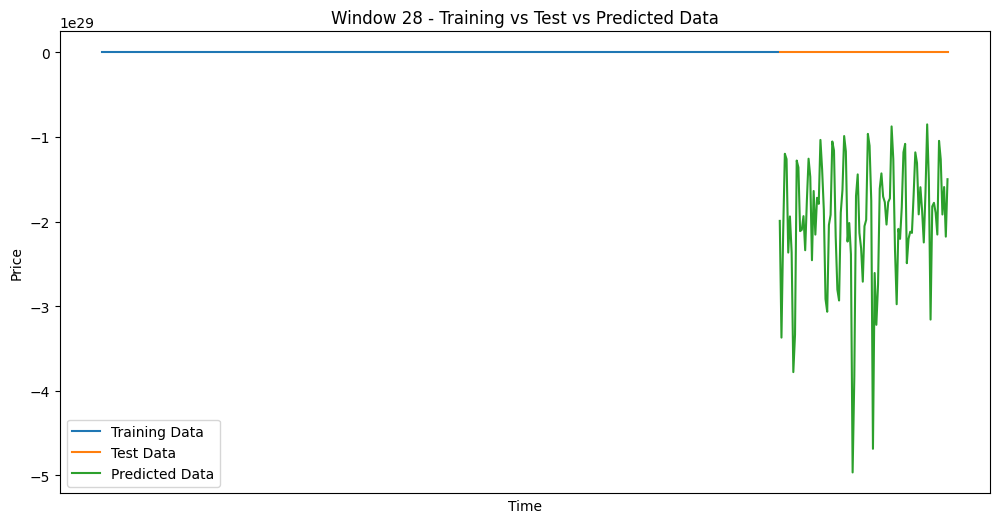

Window 29 MAE: 1.8547758006984074e+29, Window RMSE: 2.0163489483770108e+29, Window MAPE: 4.717988820671134e+26


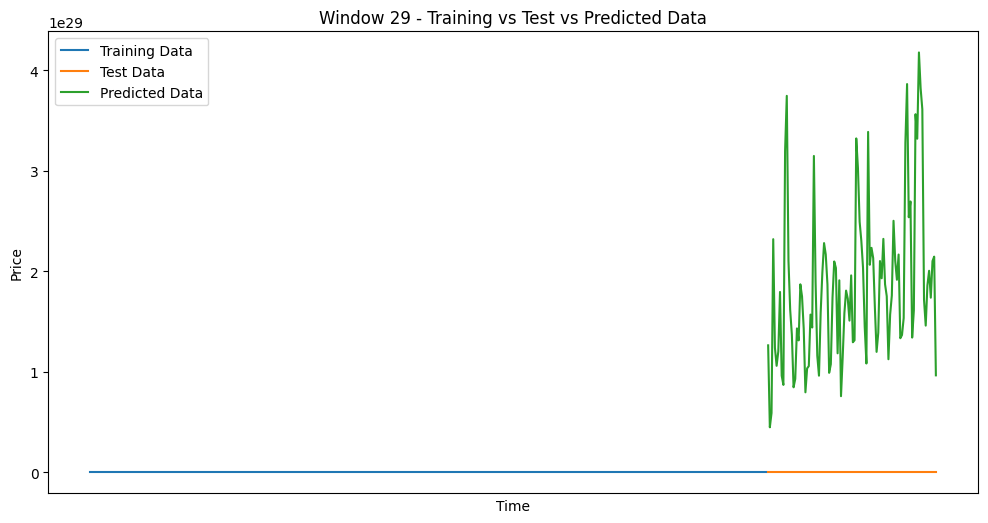

Window 30 MAE: 2.5891633439425627e+29, Window RMSE: 2.8937640297567798e+29, Window MAPE: 4.2994581140438324e+26


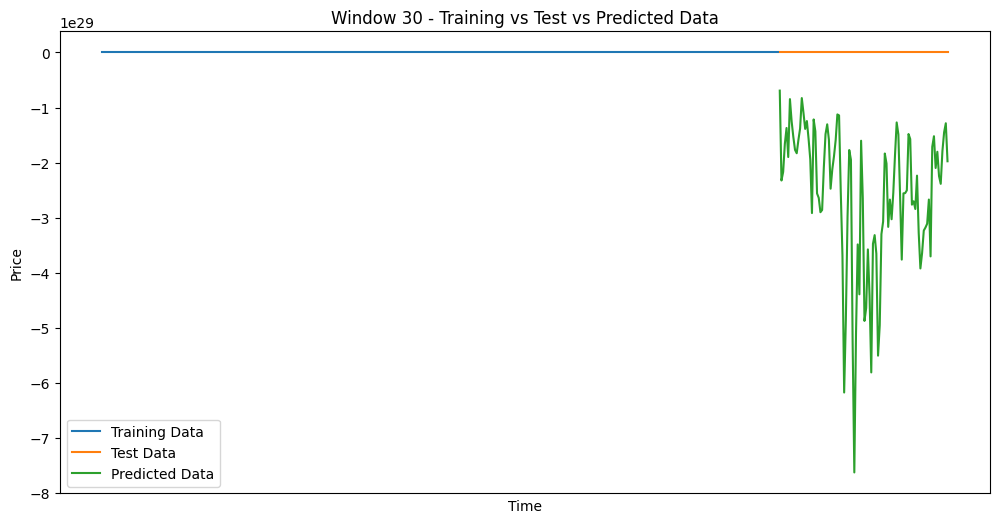

In [23]:
# Train the model over the training dataset and evaluate it on the test dataset
# Repeat the process with a new window shifted 100 days to the previous one 

# Root Mean Squared Error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# List to store the results
results = []

# Iterate over different windows of the time series dataset
for i, window in enumerate(time_series):
    # Prepare the training and testing data
    X_train = window['train'].drop(columns=['price_next_day'])
    y_train = window['train']['price_next_day']
    X_test = window['test'].drop(columns=['price_next_day'])
    y_test = window['test']['price_next_day']

    # Instantiate and train the model
    model = SGDRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict the target variable for the test set
    y_predict = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_predict)
    rmse = root_mean_squared_error(y_test, y_predict)
    mape = mean_absolute_percentage_error(y_test, y_predict)

    # Print the performance metrics for the current window
    print(f"Window {i} MAE: {mae}, Window RMSE: {rmse}, Window MAPE: {mape}")

    # Save the results
    results.append({'Window': i, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

    # Plot the training data, test data, and predicted data
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.values, label='Training Data')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test.values, label='Test Data')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_predict, label='Predicted Data')
    plt.title(f'Window {i} - Training vs Test vs Predicted Data')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks([])
    plt.legend()
    plt.show()




In [24]:
# Converting evaluation metrics to DataFrame to obtain conclusions
results_df = pd.DataFrame(results)

# Mostrar el DataFrame
print(results_df)

    Window           MAE          RMSE          MAPE
0        0  3.445749e+24  3.946976e+24  8.774350e+23
1        1  7.279210e+23  7.529476e+23  1.698414e+23
2        2  4.275792e+24  4.964675e+24  6.848297e+23
3        3  3.799774e+24  4.051199e+24  5.666327e+23
4        4  1.666556e+25  2.009910e+25  1.651782e+24
5        5  7.552210e+25  9.126736e+25  3.875707e+24
6        6  3.789078e+26  4.156953e+26  1.077972e+25
7        7  1.778975e+27  2.269934e+27  1.480711e+25
8        8  1.727644e+28  1.838470e+28  1.835998e+26
9        9  5.527356e+28  5.801721e+28  7.150364e+26
10      10  6.490837e+27  6.584580e+27  9.866723e+25
11      11  8.376289e+27  8.508223e+27  2.163937e+26
12      12  1.767429e+28  1.935219e+28  3.302304e+26
13      13  1.542401e+29  1.604653e+29  1.524770e+27
14      14  1.118758e+29  1.169779e+29  1.321318e+27
15      15  1.567193e+29  1.642572e+29  1.964275e+27
16      16  2.571885e+29  2.707755e+29  3.143134e+27
17      17  3.284538e+29  3.570577e+29  3.0772

## General Metrics Remarks

### Growing Trend

- **MAE and RMSE Increase:** Both MAE and RMSE show an overall increasing trend, suggesting that predictions become less accurate over time.
- **Spikes in Errors:** Spikes in errors (windows 19, 22, 29) can indicate times when the prediction model had particular difficulties, possibly due to sudden changes in the data or events not predicted by the model.
- **MAPE Variability:** The variability of MAPE suggests that although the absolute errors are high, their relative impact varies, which may depend on the magnitude of the predicted values in different windows.

### Specific Conclusions

- **Need for Model Revision:** The increase in errors and the presence of spikes suggests that the prediction model may need adjustments to improve its long-term performance.
- **Possible Seasonality or Anomalous Events:** Spikes in errors may indicate seasonality or anomalous events that are not being captured by the current model.
- **Continuous Evaluation:** It is crucial to continue evaluating and tuning the model, especially in windows with high errors, to understand the underlying causes and improve accuracy.

These points suggest further analysis and possibly a revision of the model to address the identified problems and improve future predictions.


## SGDRegressor Model Conclusion 

For an SGDRegressor model, we can conclude based on the results that it is not the most optimal to predict due to the volatile nature of this cryptocurrency, which gives us a clear idea that we should opt for other more efficient models.


# Deep Learning prediction

## LSTM model fitted by maximizing directional accuracy of the model

Plotting the correlation matrix for better understanding of variables.

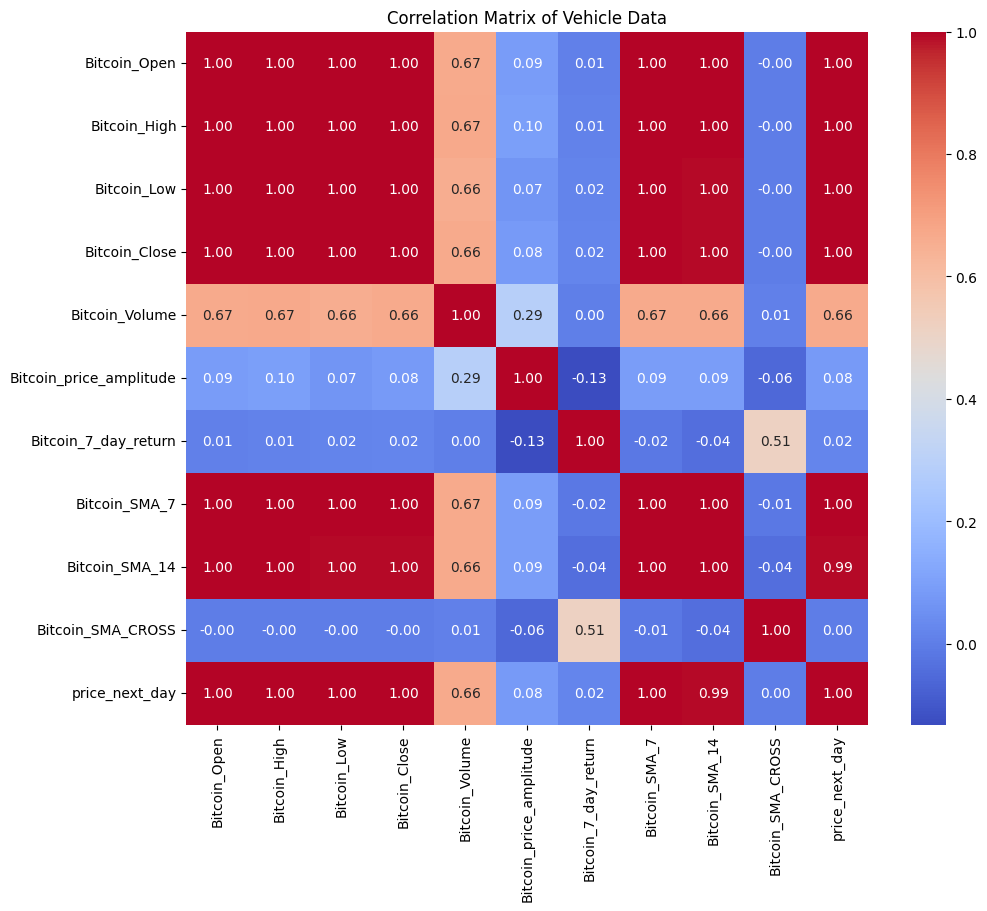

In [25]:
# Compute the correlation matrix
corr = bitcoin_cleaned[bitcoin_cleaned.describe(exclude='object').columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(11, 9))

# Draw the heatmap with numeric annotations activated
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix of Vehicle Data')
plt.show()

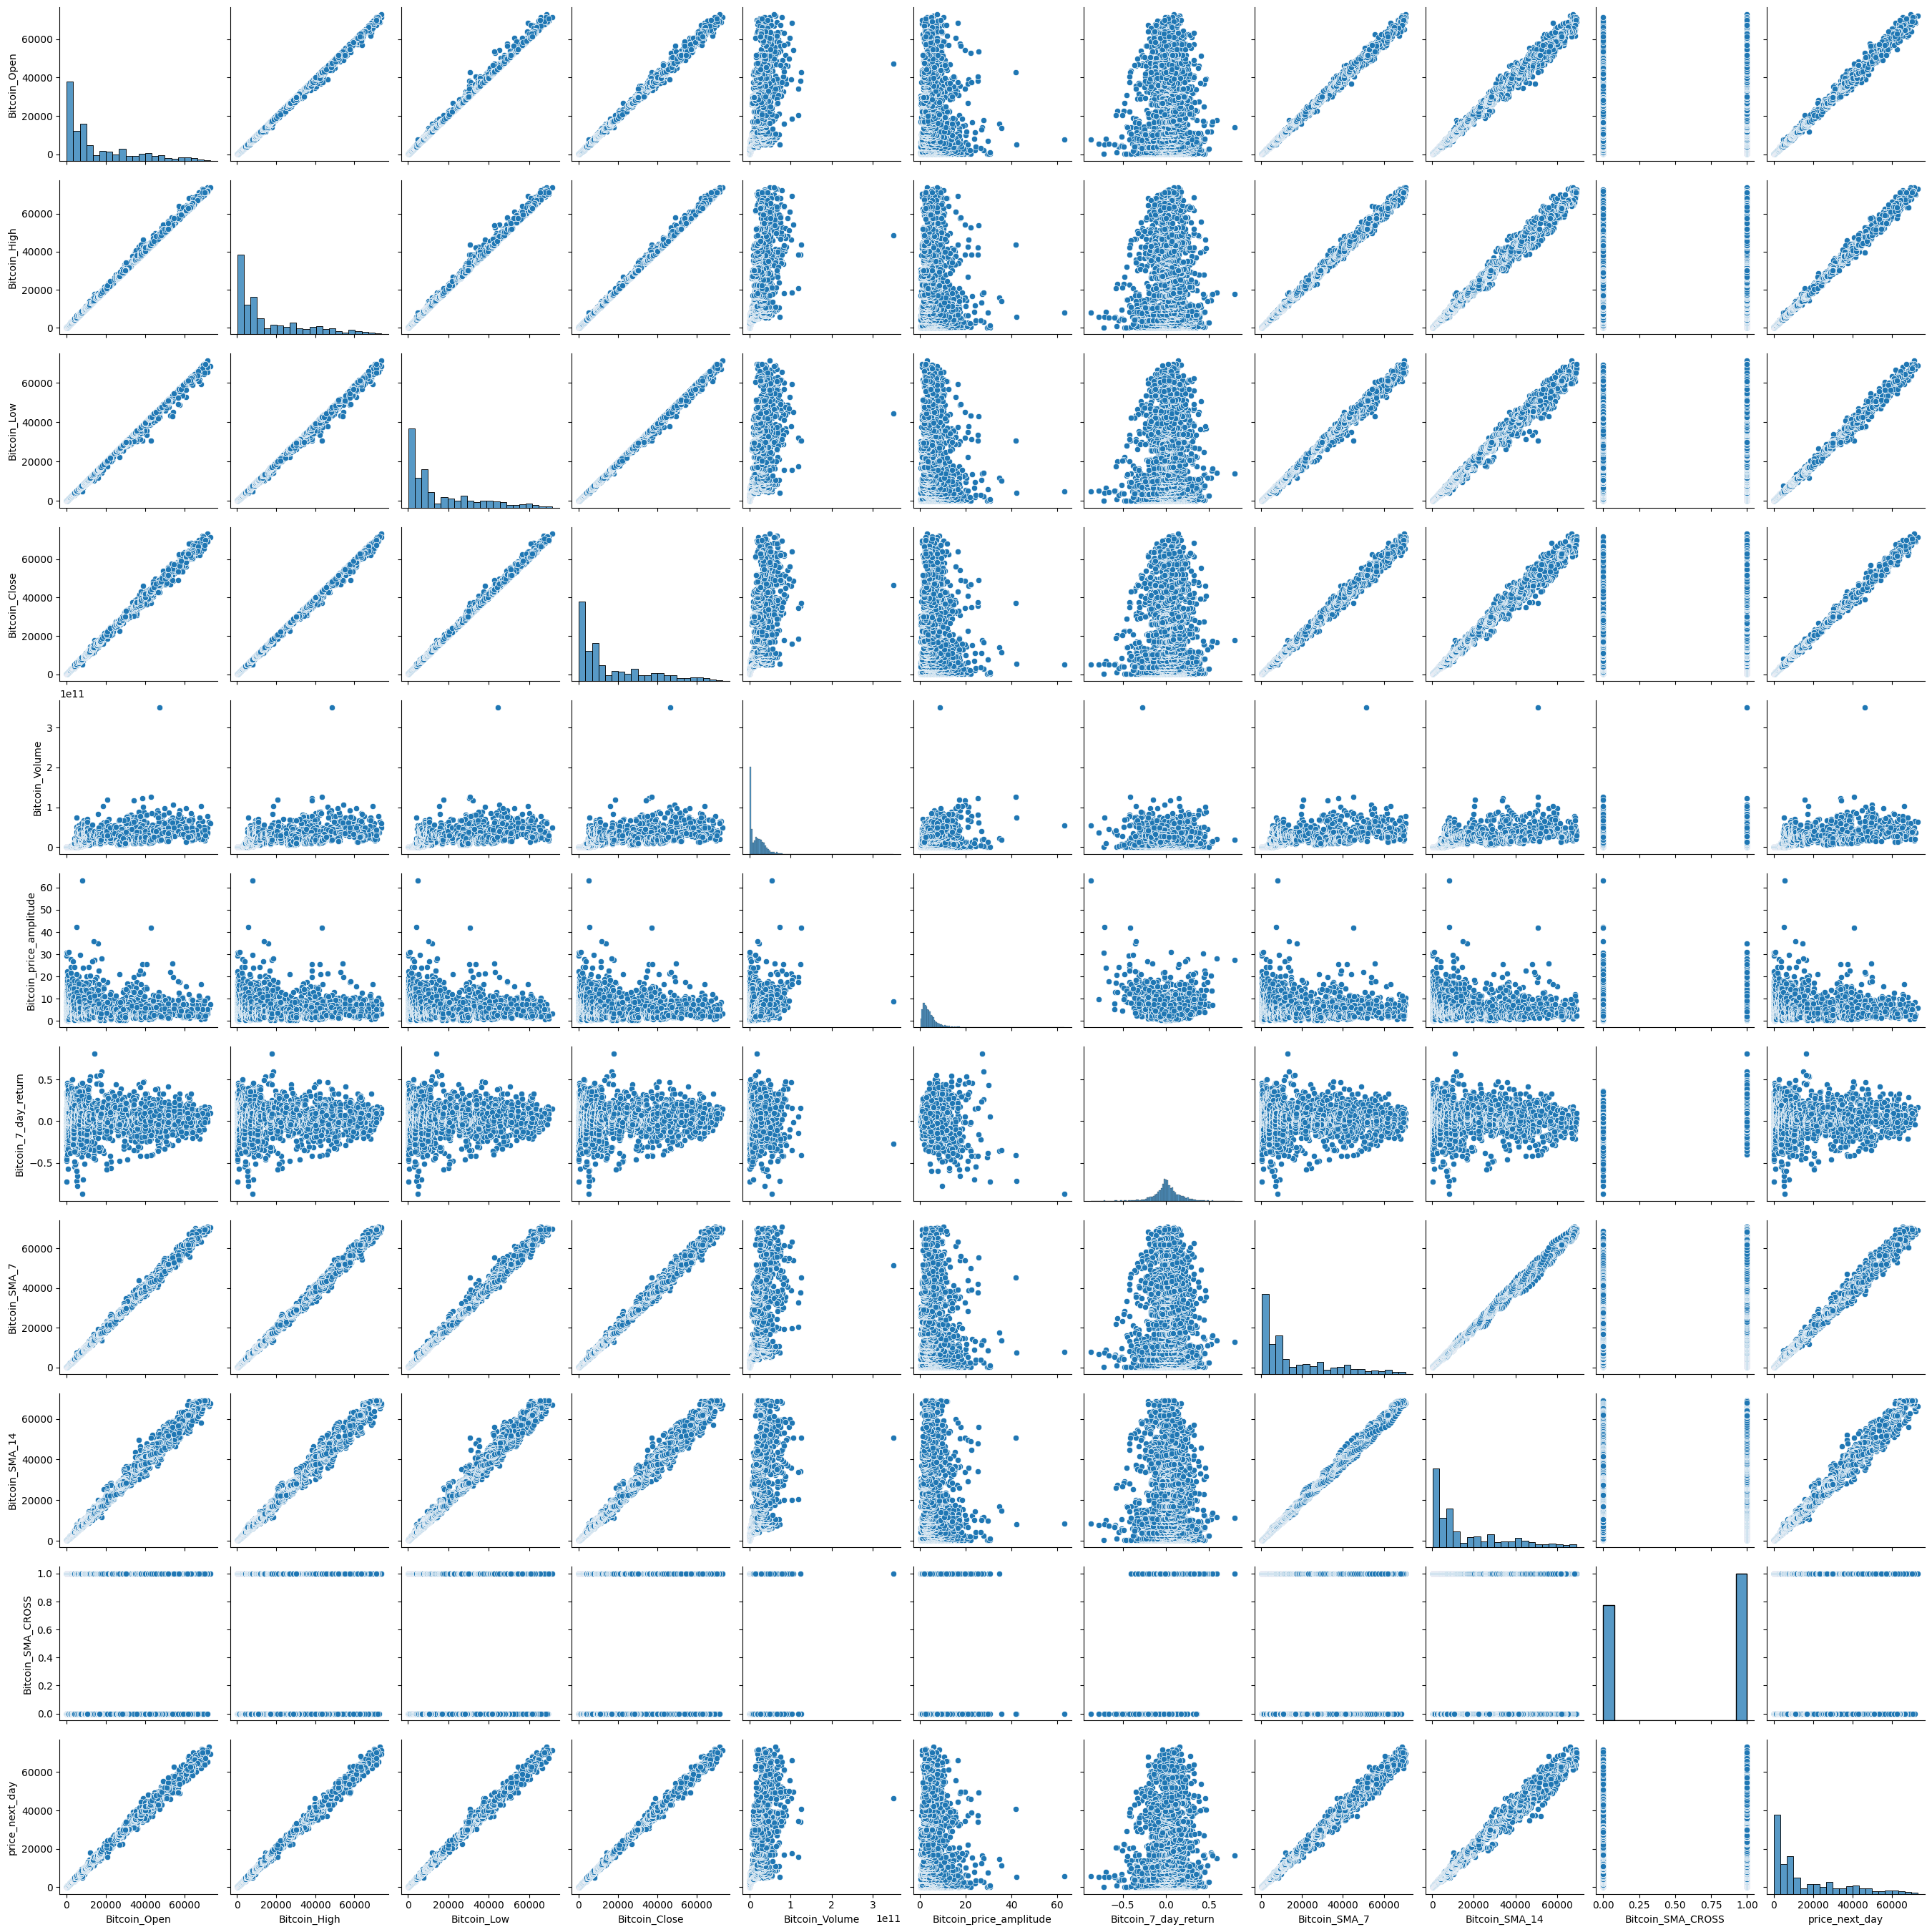

In [26]:
# Generating a pairplot to visualize relationships between variables in the bitcoin_cleaned dataset
sns.pairplot(bitcoin_cleaned)
plt.show()

Using only the closing price simplifies the model, reduces complexity, and provides a stable reflection of market consensus. 

This approach helps avoid overfitting, ensures efficient training, and often suffices for trend analysis and prediction tasks.

In [27]:
# Creating the model_data with bitcoin close price
model_data = bitcoin_cleaned['Bitcoin_Close']
model_data

Date
30/09/14      386.944000
01/10/14      383.614990
02/10/14      375.071991
03/10/14      359.511993
04/10/14      328.865997
                ...     
11/05/24    60793.710938
12/05/24    61448.394531
13/05/24    62901.449219
14/05/24    61552.789062
15/05/24    62631.992188
Name: Bitcoin_Close, Length: 3516, dtype: float64

In [28]:
# Split the model_data into training and testing sets
split_index = int(len(model_data) * 0.8)
train_data = model_data.iloc[:split_index]
test_data = model_data.iloc[split_index:]

In [29]:
# Scaling data using MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(pd.DataFrame(train_data))
scaled_test = scaler.transform(pd.DataFrame(test_data))

In [30]:
# Checking before and after scaling that we have the same amount of data
print(f'The lenght of the scaled train data is {len(scaled_train)} values')
print(f'The lenght of the unscaled train data is {len(train_data)} values')

The lenght of the scaled train data is 2812 values
The lenght of the unscaled train data is 2812 values


In [31]:
# Create look-back windows for the LSTM model
def create_lstm_data(data, look_back=60):
    
    # Creating the empty X,y lists
    X, y = [], []
    
    # Creating the look-back windows for the LSTM model
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 600
# Generating train and test final splits
X_train, y_train = create_lstm_data(scaled_train, look_back)
X_test, y_test = create_lstm_data(scaled_test, look_back)

### LSTM model configuration

- 4 layers: Different number of layers has been tried (2 to 6) and 4 layers was found the one with better results.
- 100 epochs: The ideal number of epochs to adjust to the model and avoid overfitting.
- Full batch size: Used specially in small datasets due to its computationally cost, it's found to be the most stable size in our case.
    - Size: Equal to the total number of training samples.
    - Pros: Utilizes the entire dataset to perform one update to the model weights, which can lead to stable, but slow, convergence.
    - Cons: Can be very computationally expensive and slow, especially with large datasets. It also requires significant memory, and sometimes it doesn't fit into GPU memory.
    - Typical Use: Small datasets or when the exact solution is very important.
- 600 days lookback: The ideal number of lookback days to obtain information while maintaining a significant test set size .
- adam optimizer: It was found to have better results than other optimizers like RMSprop or Adadelta.
- MSE metric: It was found to have better results than other metrics like MAE or MAPE.


In [41]:
# Initializing the model
regressor = Sequential()

# Add the first LSTM layer and apply Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Add the second LSTM layer and apply Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Add the third LSTM layer and apply Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Add the fourth LSTM layer and apply Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units = 1))

# Compile the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Adjust the LSTM model to the training set
# regressor.fit(X_train, y_train, epochs = 100, batch_size = X_train.shape[0],callbacks=[early_stopping, lr_reduction])
regressor.fit(X_train, y_train, epochs = 100, batch_size = X_train.shape[0])

# Make predictions on the test data
predicted_prices = regressor.predict(X_test)

# Inverse transform of the data
predicted_prices_final = scaler.inverse_transform(predicted_prices)[:,0]
actual_prices_final = scaler.inverse_transform(y_test)[:,0]



Epoch 1/100


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.1251
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.1024
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0821
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0601
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0376
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0194
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0207
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0342
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0262
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0151
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0109
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0120
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0144
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0152
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0135
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.01

In [42]:
# Iterate through the layer list
layers_count = 0
for layer in regressor.layers:
    # Check if the layer is not of type "Dropout" or "Dense"
    if "Dropout" not in str(layer) and "Dense" not in str(layer):
       layers_count += 1
        # Count other unspecified layers
  
        

In [43]:
loss_metric = regressor.get_metrics_result()
loss_value = list(loss_metric.values())[0]

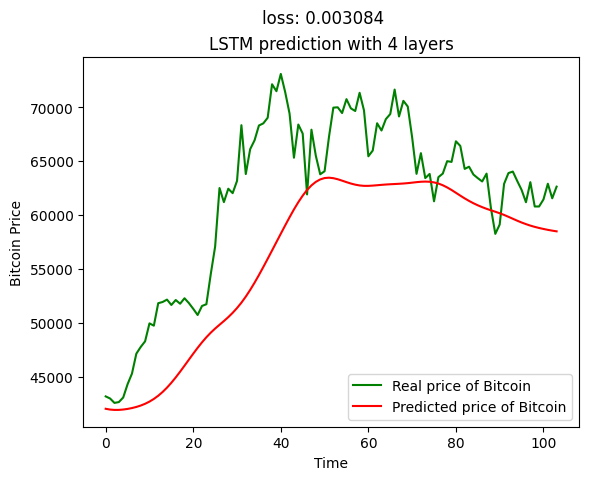

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 600, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 600, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 600, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 600, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 600, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 600, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

In [44]:
# Visualizing the results
plt.plot(actual_prices_final, color = 'green', label = 'Real price of Bitcoin')
plt.plot(predicted_prices_final, color = 'red', label = 'Predicted price of Bitcoin')
plt.title(f'LSTM prediction with {layers_count} layers')
plt.suptitle(f'loss: {round(loss_value, 6)}')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()
regressor.summary()

In [45]:
# Calculate the directional accuracy of the model by comparing the signs of actual and predicted price changes
actual_changes = np.diff(actual_prices_final)
predicted_changes = np.diff(predicted_prices_final)

actual_signs = np.sign(actual_changes)
predicted_signs = np.sign(predicted_changes)

# Compare signs and calculate accuracy
correct_predictions = np.sum(actual_signs == predicted_signs)
total_predictions = len(predicted_signs)
directional_accuracy = (correct_predictions / total_predictions)*100
print(f'Directional Accuracy of the model: {directional_accuracy}%')

Directional Accuracy of the model: 58.252427184466015%


### Brief summary of trial results

2 layers MSE:
- 'loss': 0.0006380396662279963 Acc: 46.26%
- 'loss': 0.0006226987461559474 Acc: 46.10%

2 layers MAE
- 'loss': 0.013210049830377102 Acc: 45.95%
- 'loss': 0.013036268763244152 Acc: 45.95%

2 layers RMSprop
- 'loss': 0.013865175656974316 Acc: 46.88%
- 'loss': 0.013159082271158695 Acc: 46.57%

2 layers full batch
- Acc: 50.01% 100 epochs
- Acc: 50.93% 100 epochs

4 layers full batch
- Acc: 47.66% 250 epochs 60 days lookback
- Acc: 48.44% 250 epochs 60 days lookback
- Acc: 50.66% 100 epochs 100 days lookback
- Acc: 51.1% 100 epochs 150 days lookback
- Acc: 51.39% 100 epochs 200 days lookback
- Acc: 52.24% 100 epochs 300 days lookback
- Acc: 58.25% 100 epochs 600 days lookback

6 layers MSE
- 'loss': 0.0006872758385725319 Acc: 46.10%
- 'loss': 0.0009775266516953707 Acc: 47.04%

6 layers MAE
- 'loss': 0.014898308552801609 Acc: 45.17%
- 'loss': 0.016790278255939484 Acc: 46.57%

## LSTM Model General Metrics Remarks:
- The LSTM model with 4 layers exhibited an overall directional accuracy ranging from 46.10% to 58.25% across different trials.
- The model's performance varied based on the number of layers, epochs, and lookback periods, indicating sensitivity to these parameters.
- Directional accuracy improved with a longer lookback period, suggesting the importance of historical data in predicting Bitcoin prices.
- The model's accuracy was influenced by the complexity of the architecture and training parameters, highlighting the need for fine-tuning.

## LSTM Model Conclusion:
- The LSTM model demonstrated potential for predicting Bitcoin prices with directional accuracy up to 58.25%.
- Optimal performance was achieved with a 4-layer architecture, 100 epochs, and a 600-day lookback period.
- The model's ability to capture trends and patterns in Bitcoin prices indicates its suitability for forecasting in the cryptocurrency market.
- Continuous refinement and optimization of the LSTM model parameters can further enhance its predictive capabilities for future price movements.

## Final Conclusions:

- The analysis showcased the significance of continuous model evaluation and adjustment to enhance prediction accuracy in the dynamic cryptocurrency market.
- The exploration of various models, including SGDRegressor, and LSTM, provided insights into their strengths and limitations for predicting Bitcoin prices.
- The LSTM model demonstrated potential for accurate price predictions, especially with a 4-layer architecture, 100 epochs, and a 600-day lookback period.
- Continuous refinement and optimization of model parameters are crucial for improving predictive capabilities and adapting to market trends.
- The study emphasized the importance of leveraging historical data, simplifying models for stability, and considering alternative approaches to enhance forecasting accuracy in cryptocurrency trading.

### Improving the Model and Next Steps:

- **Interactive Web Interface:** Develop a user-friendly web interface where users can input parameters, view visualizations, and receive predictions in real-time.
- **Real-Time Data Updates:** Integrate live data feeds to ensure predictions are based on the most recent information, offering users up-to-date insights.
- **Fine-Tuning Parameters:** Continuously optimize hyperparameters such as the number of layers, epochs, batch size, and lookback period to enhance model performance.
- **Feature Engineering:** Explore additional relevant features or indicators that could provide more insights into Bitcoin price movements.
- **External Data Sources:** Incorporate external data sources such as social media sentiment analysis or macroeconomic indicators to enrich the model's predictive power.
- **Correlation Analysis:** Conduct a correlation analysis between Bitcoin and other major cryptocurrencies like Ethereum, Litecoin, or Ripple to understand their price relationships.
- **Deployment and Monitoring:** Deploy the model in a production environment and establish monitoring mechanisms to track its performance and recalibrate as needed.

By implementing these strategies and steps, the model can be further refined and optimized to make more accurate predictions in the volatile cryptocurrency market.

![Alt Text](https://media1.giphy.com/media/v1.Y2lkPTc5MGI3NjExdGhudDlweGJmeGl4eWQ2bDhpazR4d3kxbnkyeHRqOGxyc2hzdXduNyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/xUPOqo6E1XvWXwlCyQ/giphy.gif)